<a href="https://colab.research.google.com/github/zaterka/DataAnalysisSkillTest-4i/blob/master/Data_Analysis_4i.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Analysis Skill Test - 4intelligence

# Pedro Zaterka


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Case 1

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
matplotlib.rcParams['figure.figsize'] = (11.0, 7.0)

## 1 - Exploratory Data Analysis



In [68]:
# as there is only one data source for case 1, the name assigned to the dataset is generic

dataframe = pd.read_csv(r'https://raw.githubusercontent.com/zaterka/DataAnalysisSkillTest-4i/master/datasets/TFP.csv')

In [69]:
# First we see how the dataframe looks like
dataframe.head()

,isocode,year,rtfpna
0,USA,1950,0.617148
1,USA,1951,0.629588
2,USA,1952,0.638451
3,USA,1953,0.651858
4,USA,1954,0.646179


In [ ]:
# Check for any empty values in the dataframe

dataframe.isna().sum()

isocode    0
year       0
rtfpna     0
dtype: int64

In [ ]:
# See if each country has the same number of years as well as if the years are the same
# And just making sure the years are in order.
dataframe.sort_values('year', ascending=True, inplace=True)
print(dataframe['isocode'].value_counts())
print(dataframe.groupby('year')['isocode'].count().reset_index().describe())

CAN    62
USA    62
MEX    62
Name: isocode, dtype: int64
              year  isocode
count    62.000000     62.0
mean   1980.500000      3.0
std      18.041619      0.0
min    1950.000000      3.0
25%    1965.250000      3.0
50%    1980.500000      3.0
75%    1995.750000      3.0
max    2011.000000      3.0


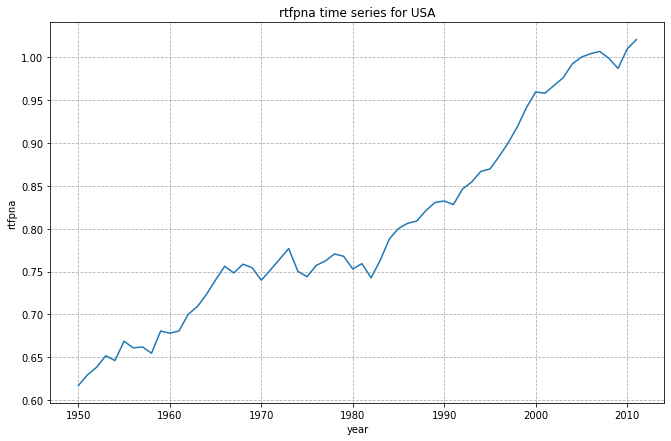

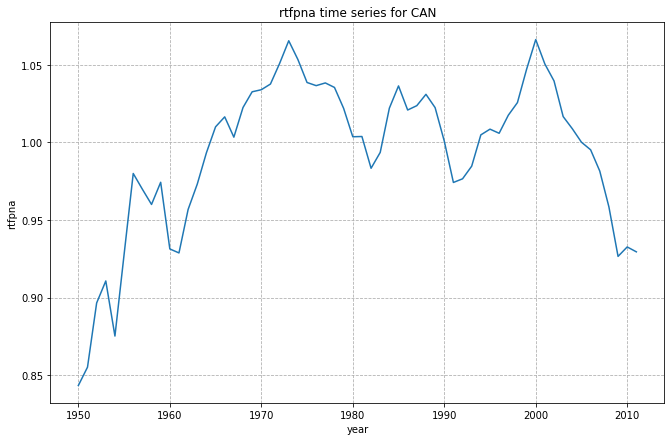

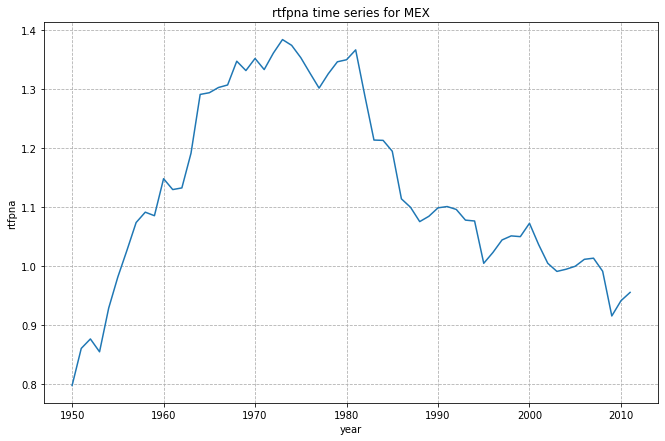

In [ ]:
# Now that it is known that all countries contain all years from 1980 to 2011
# we can plot their time series separately to see how they behave

for valor in dataframe['isocode'].drop_duplicates():
  df_country = dataframe.loc[dataframe['isocode'] == valor]
  sns.lineplot(x='year', y='rtfpna', data=df_country)
  plt.title(f'rtfpna time series for {valor}')
  plt.grid(linestyle='dashed')
  plt.show()

There is a visible difference when comparing each of the countries. For instance, USA has a constant growth from the early 1980s, after a period of stagnation.

Meanwhile, Canada has a much bumpier tragetory, having a considerable decrease since 2000.

For Mexico, it had a substantial increase from 1950 to 1974, and has been decreasing since 1980.

## 2 - Forecast 10 years of the series

For the time series forecast, the method chosen was ARIMA, for its reproducibility in the R package **forecast**.

In [4]:
from pandas import datetime
from pandas import DataFrame
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [ ]:
country_list=['USA', 'CAN', 'MEX']

Autocorrelation and Partial Autocorrelation for USA


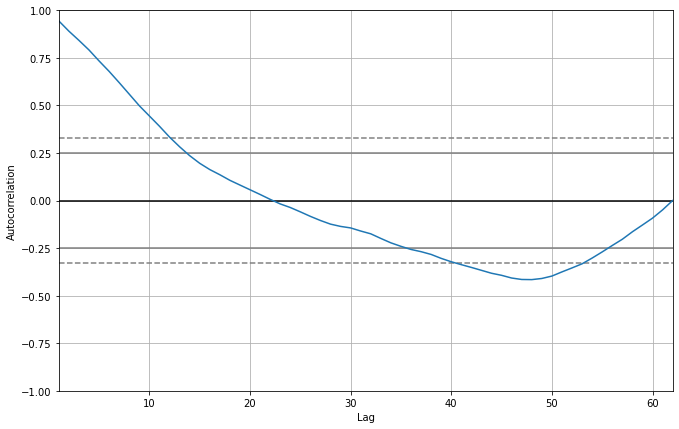

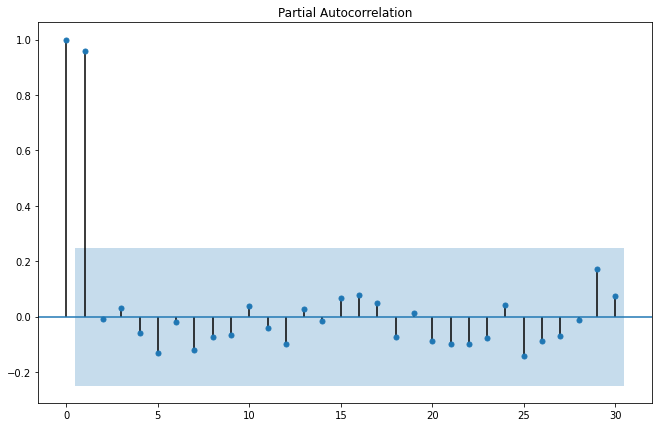

Autocorrelation and Partial Autocorrelation for CAN


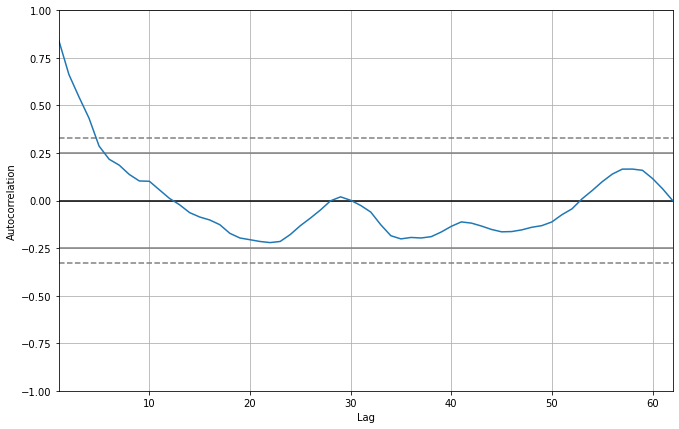

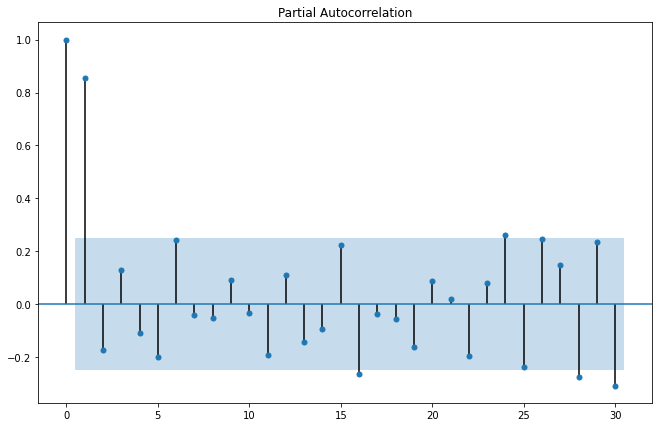

Autocorrelation and Partial Autocorrelation for MEX


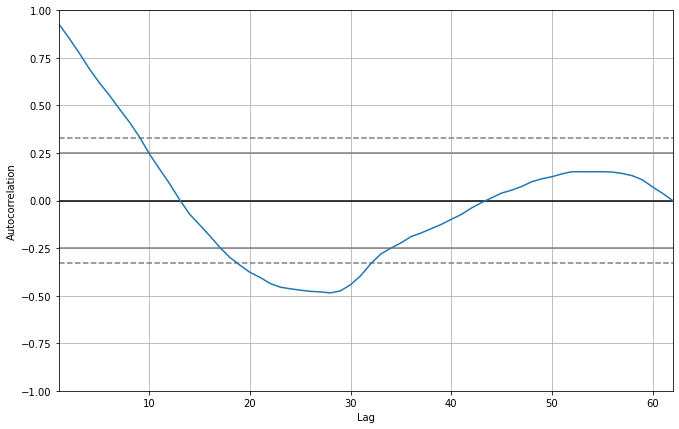

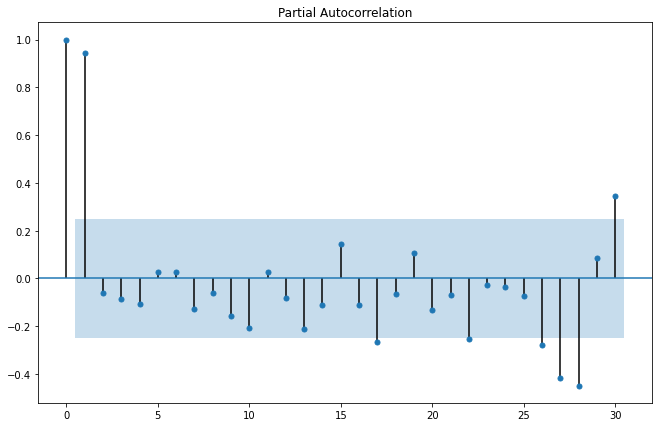

In [ ]:
# To determine the parameters p and q of the ARIMA model for each country, 
# the autocorrelation and partial autocorrelation are plotted
for country in country_list:
  print(f'Autocorrelation and Partial Autocorrelation for {country}')
  series = dataframe.loc[dataframe['isocode'] == country, 'rtfpna'].values
  autocorrelation_plot(series)
  plt.show()
  plot_pacf(series, lags=30)
  plt.show()

In [ ]:
# Using the values observed in the graphs as an estimation,
# now evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = len(X) - 10
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	model = ARIMA(history, order=arima_order)
	model_fit = model.fit(disp=0)
  # specify for it to predict 10 out of samples steps
	yhat = model_fit.forecast(steps=10)[0]
	predictions = list(yhat)
  # calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					
				except:
					continue
	print('Best ARIMA%s MSE=%.6f' % (best_cfg, best_score))
 

# Applying the functions for each country
for country in ['USA', 'CAN', 'MEX']:
	X = dataframe.loc[dataframe['isocode'] == country, 'rtfpna'].values
	print(country)
	p_values = [4, 5, 6, 7, 8, 9, 10, 11, 12]
	d_values = range(0, 3)
	q_values = range(0, 3)
	evaluate_models(X, p_values, d_values, q_values)

USA
Best ARIMA(6, 0, 0) MSE=0.000081
CAN
Best ARIMA(8, 2, 1) MSE=0.001328
MEX
Best ARIMA(9, 2, 2) MSE=0.000502


In [ ]:
list_param = [('USA', (6, 0, 0)), ('CAN', (8, 2, 1)), ('MEX', (9, 2, 2))]

Results for USA
Test MSE: 0.000080


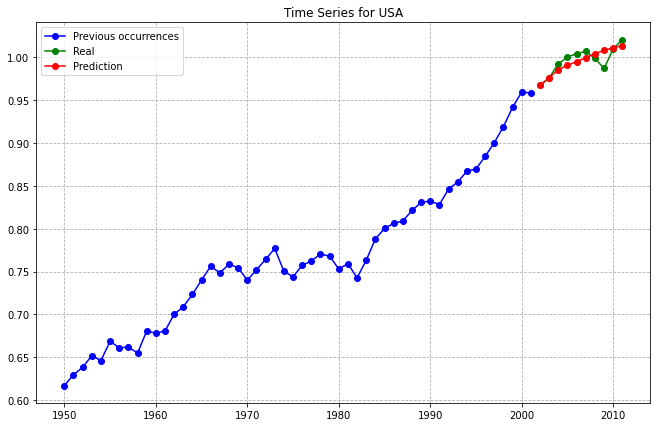

Results for CAN
Test MSE: 0.001328


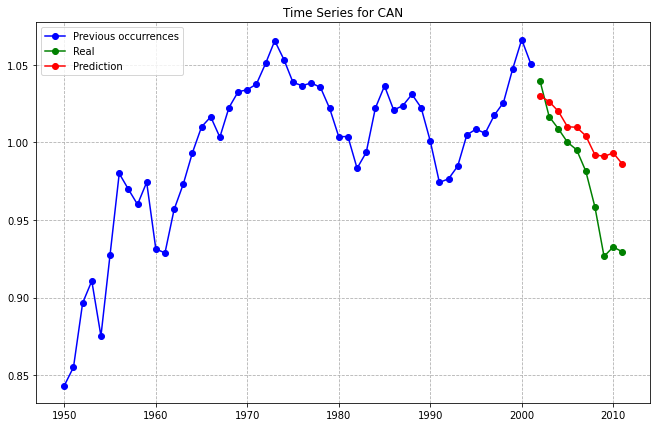

Results for MEX
Test MSE: 0.000964


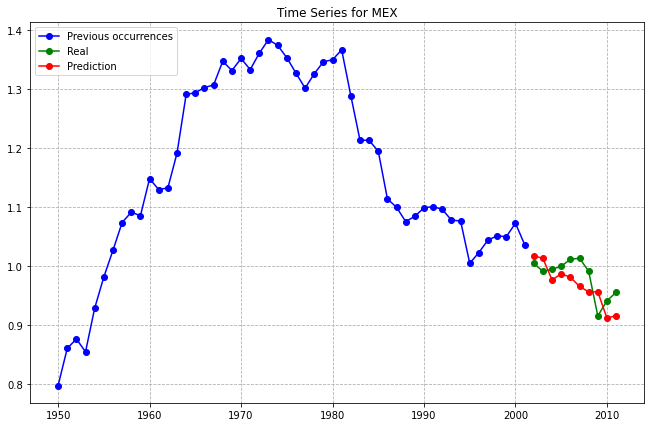

In [ ]:
dates = dataframe['year'].drop_duplicates().values
for country, pqd in list_param:
  print(f'Results for {country}')
  X = dataframe.loc[dataframe['isocode'] == country, 'rtfpna'].values
  model = ARIMA(X[:-10], order=pqd)
  model_fit = model.fit(disp=0)
  output = model_fit.forecast(steps=10)
  predictions = output[0]
  test = X[-10:]
  error = mean_squared_error(test, predictions)
  print('Test MSE: %.6f' % error)
  # plot
  plt.plot(dates[:-10], X[:-10], color = 'blue', marker='o', label='Previous occurrences')
  plt.plot(dates[-10:], X[-10:], color = 'green', marker='o', label='Real')
  plt.plot(dates[-10:], predictions, color='red', marker='o', label = 'Prediction')
  plt.legend(loc='upper left')
  plt.grid(linestyle='dashed')
  plt.title(f'Time Series for {country}')
  plt.show()

## 3 - Can you think about another feature that could be helpful in explaining TFP series? Explain.

* **hc** - Index of human capital per person, based on years of schooling (Barro and Lee 2013) and returns to education (Psacharopoulos 1994)

The index of human capital can be useful in this analysis, as human capital assigns a value on individual knowledge, skills and attributes of a person, it can be a way to measure productivity of the individual. 

It can provide insights regarding TFP and helping explain changes and discontinuities in the series.







# Case 2

In [70]:
df_case2 = pd.read_csv(r'https://raw.githubusercontent.com/zaterka/DataAnalysisSkillTest-4i/master/datasets/data_comexstat.csv', encoding='iso-8859-1')

In [71]:
df_case2.head()

,date,product,state,country,type,route,tons,usd
0,1997-01-01,corn,ES,United States,Import,Sea,44.045,113029.0
1,1997-01-01,corn,GO,Argentina,Import,Ground,54.000,36720.0
2,1997-01-01,corn,GO,Bolivia,Export,Ground,0.200,180.0
3,1997-01-01,corn,GO,United States,Export,Sea,3.488,5688.0
4,1997-01-01,corn,MG,Argentina,Import,Ground,27.000,18630.0


In [ ]:
df_case2.shape
df_case2.dtypes

date        object
product     object
state       object
country     object
type        object
route       object
tons       float64
usd        float64
dtype: object

In [ ]:
# Check for any empty values in the dataframe

df_case2.isna().sum()

date       0
product    0
state      0
country    0
type       0
route      0
tons       0
usd        0
dtype: int64

In [6]:
# Convert date to datetime
df_case2['date'] = pd.to_datetime(df_case2['date'], format='%Y-%m-%d')

## 1 - Show the evolution of total monthly and total annual exports from Brazil (all states and to everywhere) of ‘soybeans’, ‘soybean oil’ and ‘soybean meal’

In [ ]:
# See how the products are written in the dataframe
print(df_case2['product'].value_counts())

sugar           35202
soybeans        22914
corn            21872
soybean_meal    18215
soybean_oil     16116
wheat            3646
Name: product, dtype: int64


In [7]:
# Creating year and month columns
df_case2['year'] = df_case2['date'].dt.year
df_case2['month'] = df_case2['date'].dt.month.astype(str) + '-' + df_case2['date'].dt.year.astype(str)

list_products = ['soybeans', 'soybean_oil', 'soybean_meal']
df_exports = df_case2.query("type == 'Export'") # filtering export products

df_products = df_exports.loc[df_exports['product'].isin(list_products)] # getting values for requested products

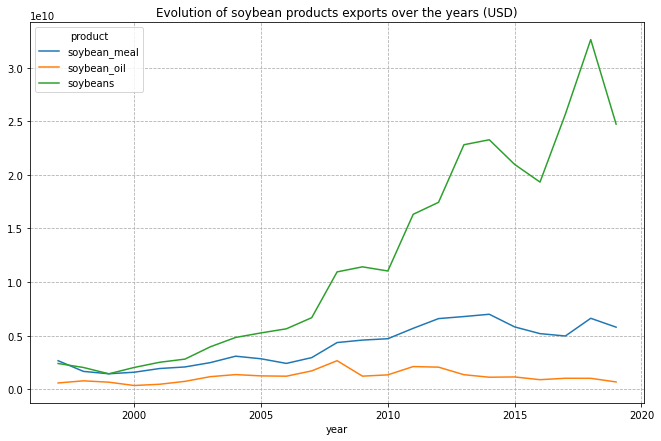

In [ ]:
# getting yearly exports for each product
prod_evolution_year = df_products.pivot_table(index = 'product', columns = 'year', values = 'usd', aggfunc = 'sum')
prod_evolution_year.T.plot()
plt.title('Evolution of soybean products exports over the years (USD)')
plt.grid(linestyle='dashed',which='both')
plt.show()

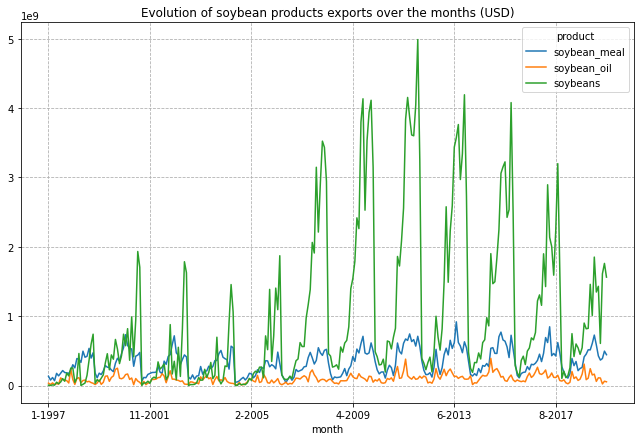

In [ ]:
# getting monthly exports for each product
prod_evolution_month = df_products.pivot_table(index = 'product', columns = 'month', values = 'usd', aggfunc = 'sum')
prod_evolution_month.T.plot()
plt.title('Evolution of soybean products exports over the months (USD)')
plt.grid(linestyle='dashed',which='both')
plt.show()

## 2 - What are the 3 most important products exported by Brazil in the last 5 years?

In [ ]:
df_last_years = df_exports.query('year >= 2015') # getting values from 2015 onwards

In [ ]:
# By USD
pd.options.display.float_format = '{:.2f}'.format
df_last_years.groupby('product', as_index=False)['usd'].sum().sort_values('usd', ascending=False).head(3)

,product,usd
3,soybeans,123325529857.00
4,sugar,40938486021.00
1,soybean_meal,28407723437.00


In [ ]:
# By Tons
df_last_years.groupby('product', as_index=False)['tons'].sum().sort_values('tons', ascending=False).head(3)

,product,tons
3,soybeans,326331464.07
0,corn,144599338.17
4,sugar,120033648.71


## 3 - What are the main routes through which Brazil have been exporting ‘corn’ in the last few years? Are there differences in the relative importance of routes depending on the product?

In [ ]:
df_exports['route'].value_counts() # getting the values

Sea       88834
Ground     7450
Other      6355
River      1740
Air        1482
Name: route, dtype: int64

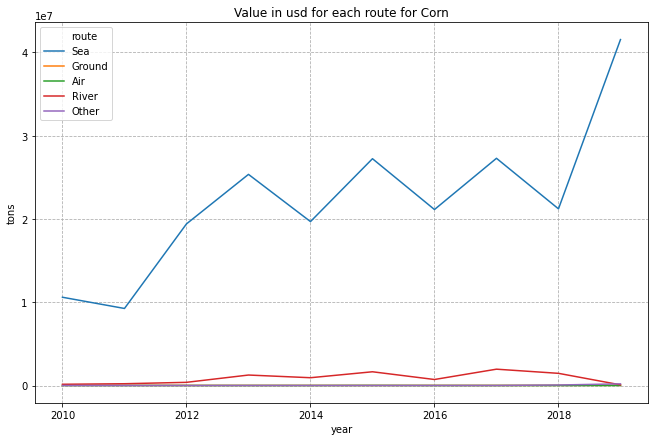

In [8]:
# getting exports by year for corn
df_corn_routes = df_exports.query("product == 'corn' & year >= 2010")
sns.lineplot(x='year', y='tons', hue='route', data=df_corn_routes, estimator=sum, err_style=None)
plt.title('Value in usd for each route for Corn')
plt.grid(linestyle='dashed',which='both')
plt.show()

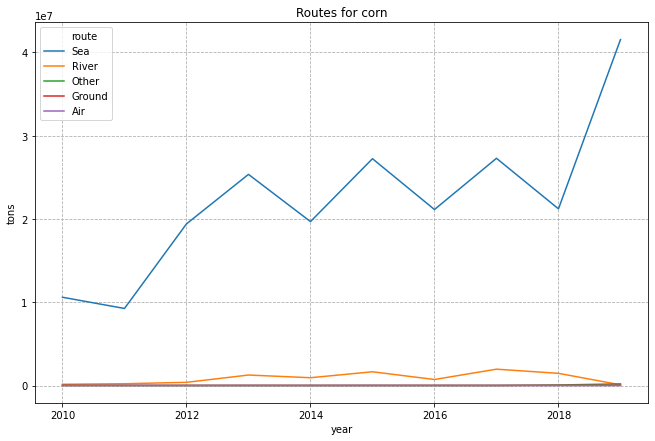

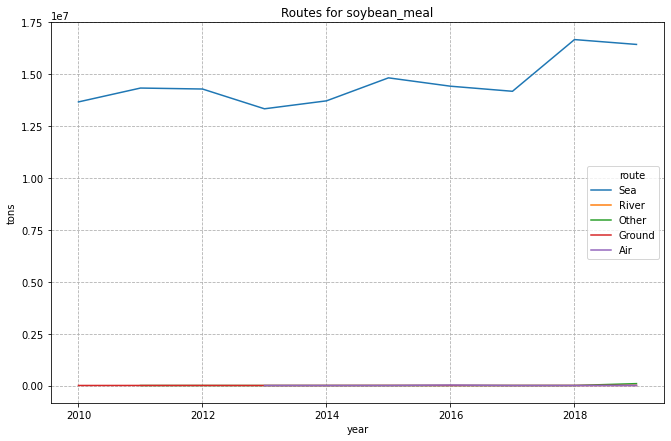

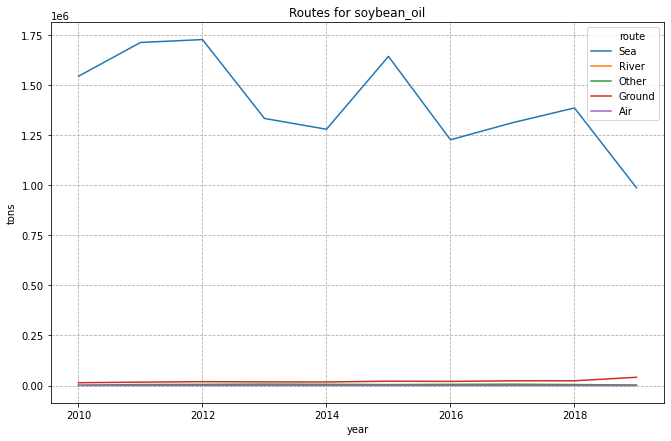

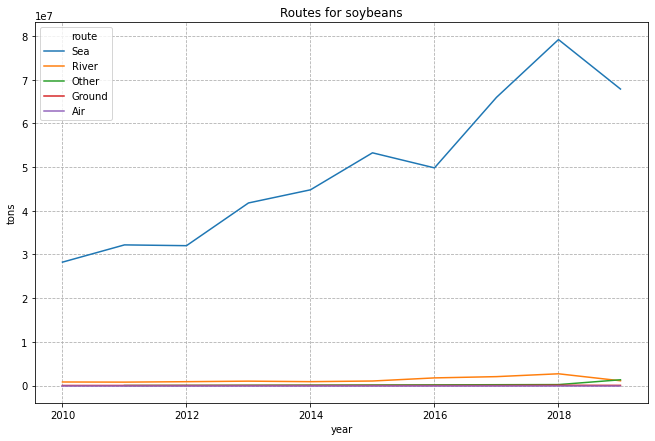

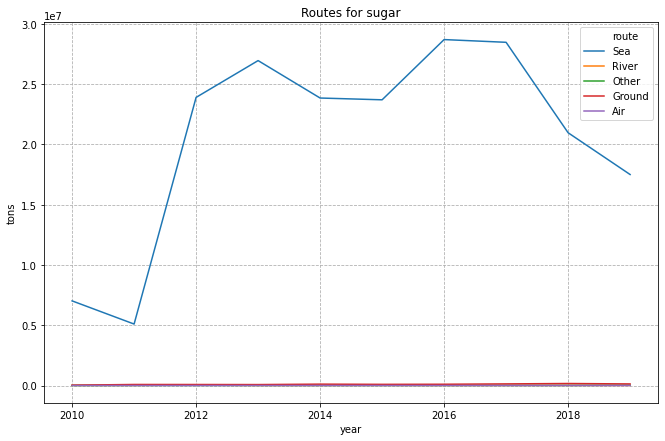

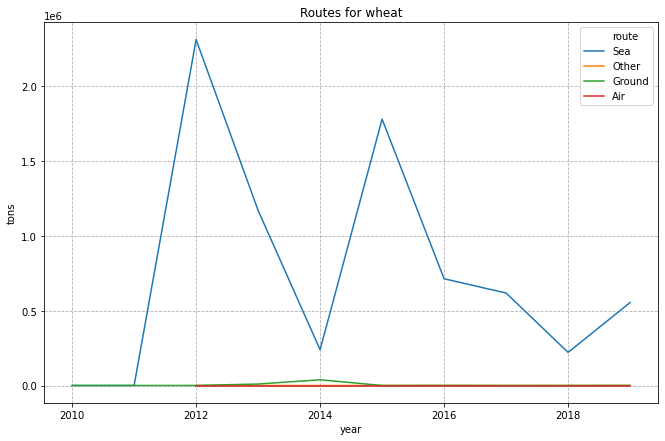

In [12]:
for product in df_exports['product'].drop_duplicates(): # exports by product for each year
  df_routes = df_exports.query(f"product == '{product}' & year >= 2010")
  sns.lineplot(x='year', y='tons', hue='route', data=df_routes.sort_values('route', ascending=False), estimator=sum, err_style=None)
  plt.title(f'Routes for {product}')
  plt.grid(linestyle='dashed',which='both')
  plt.show()

Exports by sea seem to be the predominant modal in all products presented in the dataframe,  by a considerable margin.

This is partially expected for transport by sea in much cheaper than by air or by ground, as well as more viable depending on the destination, especially when compared to ground transportation.

## 4 - Which countries have been the most important trade partners for Brazil in terms of ‘corn’ and ‘sugar’ in the last 3 years?

For this analysis, both imports and exports were considered.

In [15]:
df_corn = df_case2.loc[(df_case2['product'] == 'corn') &
                          (df_case2['year'] >= 2017)]

print('Corn trade partners\n', 
      df_corn.groupby('country', as_index=False)['tons'].sum().sort_values('tons', ascending=False).head(5))

Corn trade partners
      country          tons
46      Iran  1.642565e+07
53     Japan  9.676921e+06
110  Vietnam  9.446982e+06
31     Egypt  8.353797e+06
93     Spain  8.243946e+06


In [16]:
df_sugar = df_case2.loc[(df_case2['product'] == 'sugar') & # 
                          (df_case2['year'] >= 2017)]
print('Sugar trade partners\n', 
      df_sugar.groupby('country', as_index=False)['tons'].sum().sort_values('tons', ascending=False).head(5))


Sugar trade partners
                   country         tons
2                 Algeria  6696854.262
13             Bangladesh  6331640.155
68                  India  5111371.882
148  United Arab Emirates  4545802.219
120          Saudi Arabia  4249461.903


## 5- For each of the products in the dataset, show the 5 most important states in terms of exports?

In [ ]:
for prod in df_exports['product'].drop_duplicates():
  df_prod_exp = df_exports.loc[df_exports['product'] == prod]
  print(f'Top 5 states for {prod}')
  print(df_prod_exp.groupby('state', as_index=False)['usd'].sum().sort_values('usd', ascending=False).head(5))

Top 5 states for corn
   state            usd
12    MT 28375516035.00
17    PR  9160511995.00
8     GO  5706990655.00
11    MS  3405430680.00
24    SP  1511121926.00
Top 5 states for soybean_meal
   state            usd
10    MT 27994539842.00
14    PR 24649962821.00
19    RS 15007385729.00
6     GO  9421430703.00
3     BA  5439265638.00
Top 5 states for soybean_oil
   state            usd
16    PR 11109102057.00
20    RS  6281965055.00
12    MT  5434513926.00
21    SC  1238810673.00
8     GO   855920734.00
Top 5 states for soybeans
   state            usd
11    MT 80506781707.00
16    PR 48484101052.00
20    RS 46136733396.00
7     GO 21268827303.00
10    MS 13284815678.00
Top 5 states for sugar
   state            usd
25    SP 66211861392.00
10    MG  8559401218.00
17    PR  8270778644.00
1     AL  4826419200.00
11    MS  3219034929.00
Top 5 states for wheat
   state           usd
9     RS 1555925283.00
6     PR  183935397.00
10    SC   25400089.00
11    SP    2267024.00
5     MS    

## 6 - Now, we ask you to show your modelling skills. Feel free to use any type of modelling approach, but bear in mind that the modelling approach depends on the nature of your data, and so different models yield different estimates and forecasts. To help you out in this task we also provide you with a dataset of possible covariates (.xlsx). They all come from public sources (IMF, World Bank) and are presented in index number format. Question: What should be the total brazilian soybeans, soybean_meal, and corn export forecasts, in tons, for the next 11 years (2020-2030)? We’re mostly interested in the annual forecast.

In [72]:
# reading the covariates excel file from github
df_covariates = pd.read_excel(r'https://raw.githubusercontent.com/zaterka/DataAnalysisSkillTest-4i/master/datasets/covariates.xlsx')

The products were analyzed separately for a better determination of the predictive model for each case

### Product: Corn

In [73]:
df_corn_exp = df_exports.query("product == 'corn'")

In [74]:
df_corn_exp

,date,product,state,country,type,route,tons,usd,year,month
2,1997-01-01,corn,GO,Bolivia,Export,Ground,0.200,180.0,1997,1-1997
3,1997-01-01,corn,GO,United States,Export,Sea,3.488,5688.0,1997,1-1997
5,1997-01-01,corn,MS,Paraguay,Export,Ground,40.000,38700.0,1997,1-1997
9,1997-01-01,corn,PR,Netherlands,Export,Sea,170000.000,20000000.0,1997,1-1997
10,1997-01-01,corn,PR,Paraguay,Export,Ground,258.300,386733.0,1997,1-1997
...,...,...,...,...,...,...,...,...,...,...
117265,2019-12-01,corn,SP,Vietnam,Export,Sea,2575.793,402284.0,2019,12-2019
117266,2019-12-01,corn,TO,Egypt,Export,Sea,27908.815,4433950.0,2019,12-2019
117267,2019-12-01,corn,TO,Kuwait,Export,Sea,1293.930,229003.0,2019,12-2019
117268,2019-12-01,corn,TO,Philippines,Export,Air,0.007,27.0,2019,12-2019


In [75]:
# Printing the main export destinations
print(df_corn_exp.groupby('country', as_index=False)['tons'].sum().sort_values('tons', ascending=False).head(15))

                country          tons
55                 Iran  4.880114e+07
62                Japan  2.611666e+07
109         South Korea  2.548511e+07
130             Vietnam  2.210505e+07
110               Spain  1.954909e+07
116              Taiwan  1.748387e+07
36                Egypt  1.746728e+07
70             Malaysia  1.309373e+07
103        Saudi Arabia  8.413122e+06
78              Morocco  8.127749e+06
83          Netherlands  6.726602e+06
2               Algeria  6.160030e+06
54            Indonesia  5.777154e+06
98             Portugal  4.951751e+06
34   Dominican Republic  4.822812e+06


In [21]:
# getting exports by year
df_corn_yearly = df_corn_exp.groupby('year', as_index=False)['tons'].sum()

In [ ]:
df_corn_yearly

,year,tons
0,1997,3.568950e+05
1,1998,6.033643e+03
2,1999,5.321076e+03
3,2000,5.554756e+03
4,2001,5.410199e+06
5,2002,2.727390e+06
6,2003,3.509735e+06
7,2004,4.892188e+06
8,2005,1.069452e+06
9,2006,3.936310e+06


In [22]:
# Now adding the new data from the covariates files

df_corn_yearly = df_corn_yearly.merge(df_covariates, left_on='year', right_on='year', how='left')

In [23]:
# Droping the columns which refers to other products

df_corn_yearly.drop(columns=['price_soybeans', 'price_soybean_meal'], inplace=True)

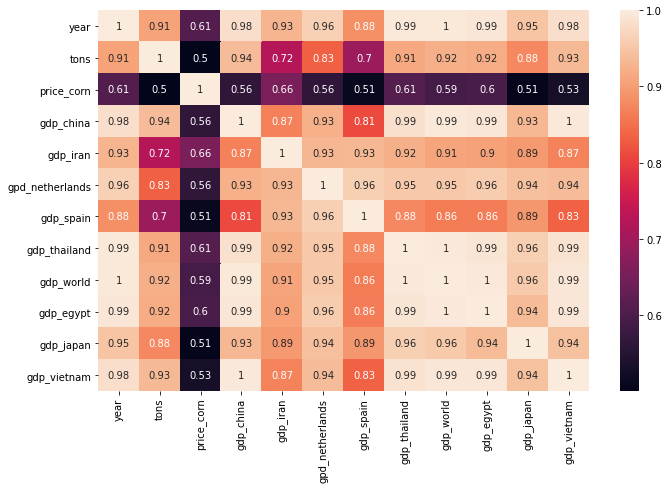

In [ ]:
# Checking for correlations between variables

sns.heatmap(df_corn_yearly.corr(), annot=True)
plt.show()

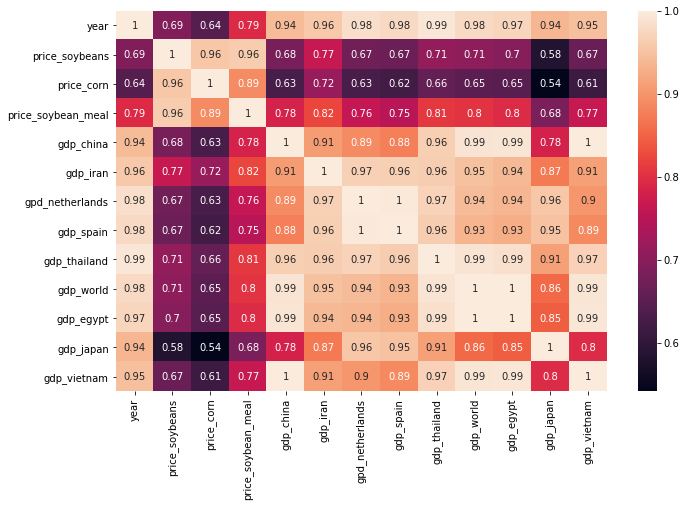

In [ ]:
# Checking correlation in all covariates dataset

sns.heatmap(df_covariates.corr(), annot=True)
plt.show()

In [ ]:
gdps = list(df_covariates.columns)
to_remove = ['year', 'price_soybeans', 'price_soybean_meal']
gdps = [e for e in gdps if e not in to_remove]
gdps

['price_corn',
 'gdp_china',
 'gdp_iran',
 'gpd_netherlands',
 'gdp_spain',
 'gdp_thailand',
 'gdp_world',
 'gdp_egypt',
 'gdp_japan',
 'gdp_vietnam']

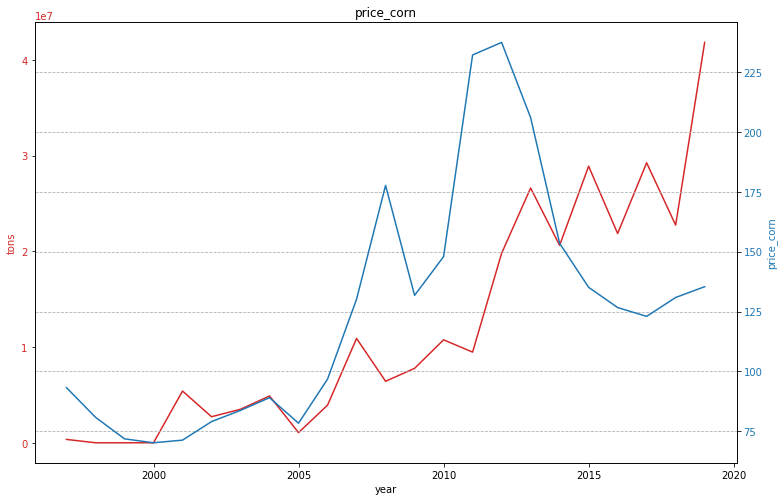

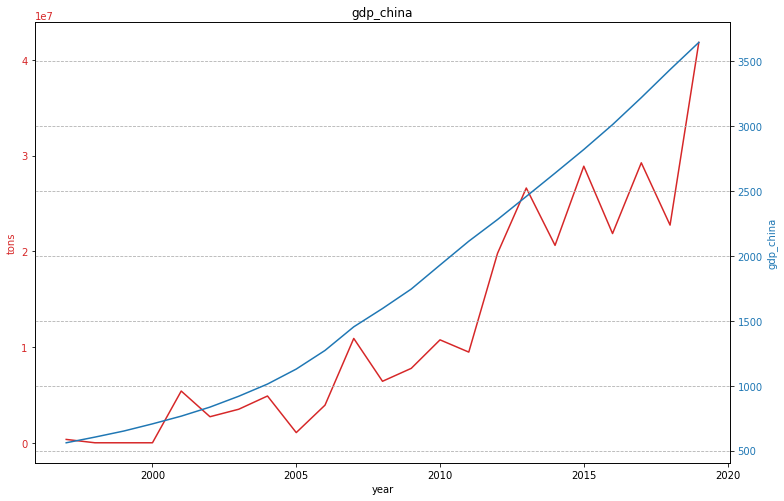

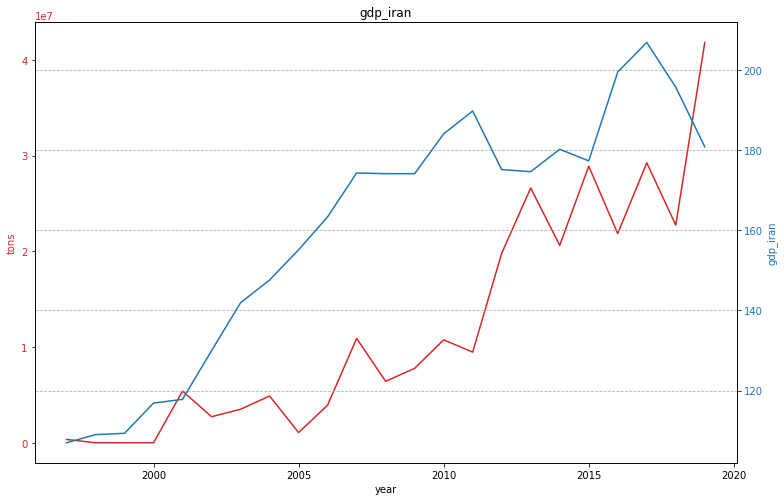

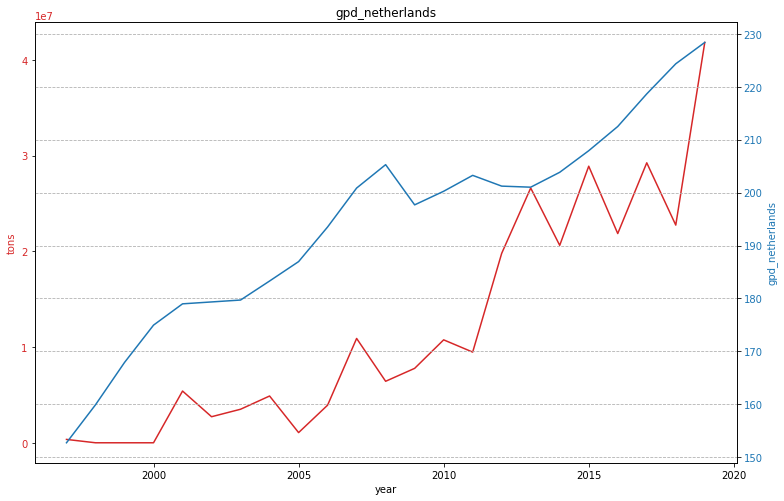

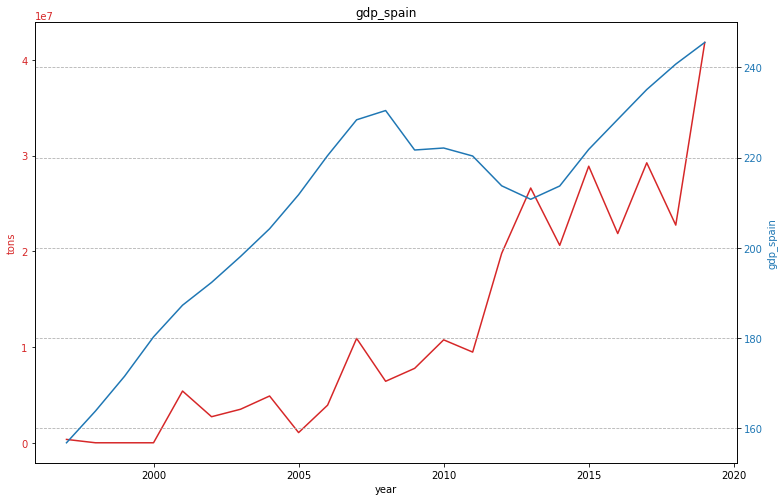

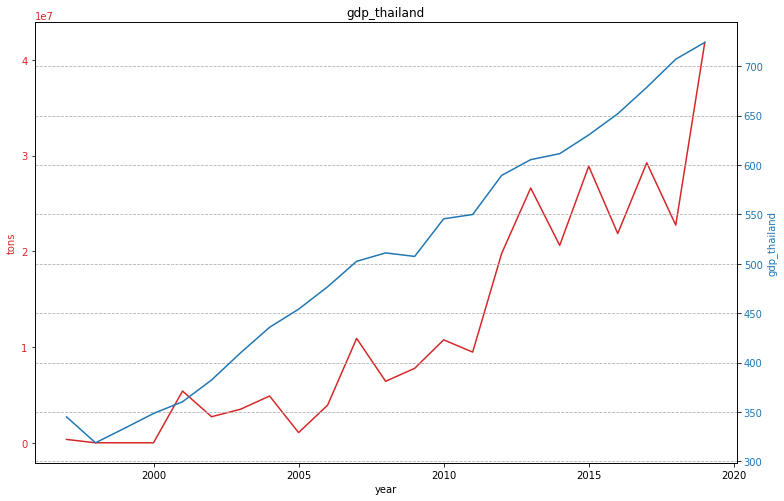

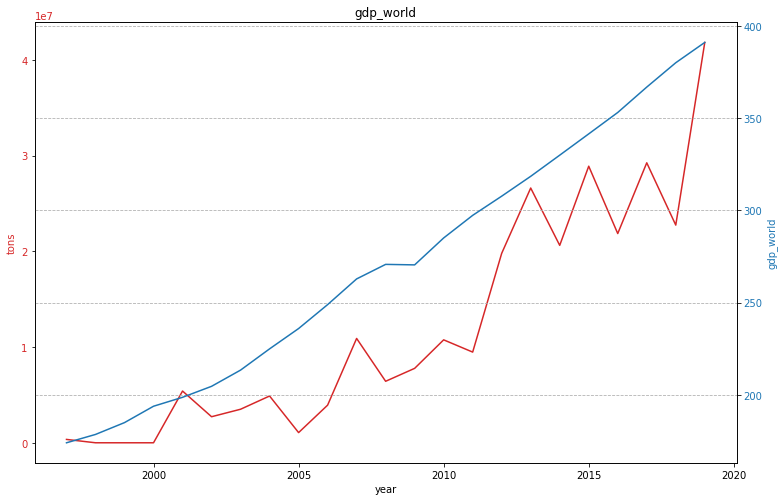

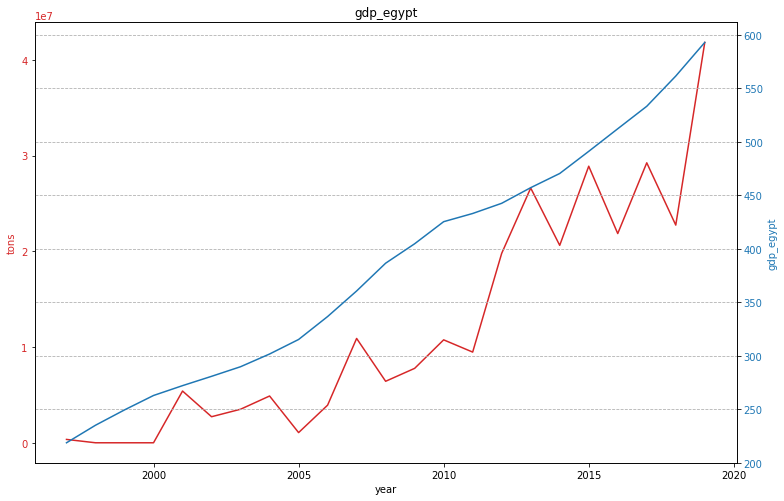

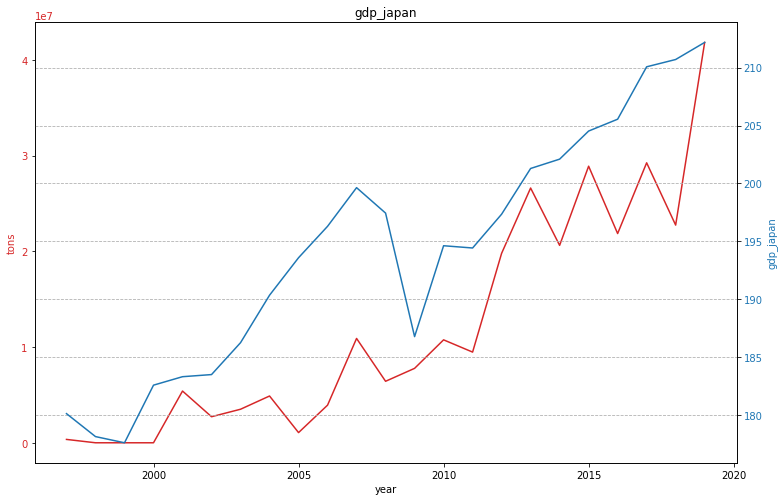

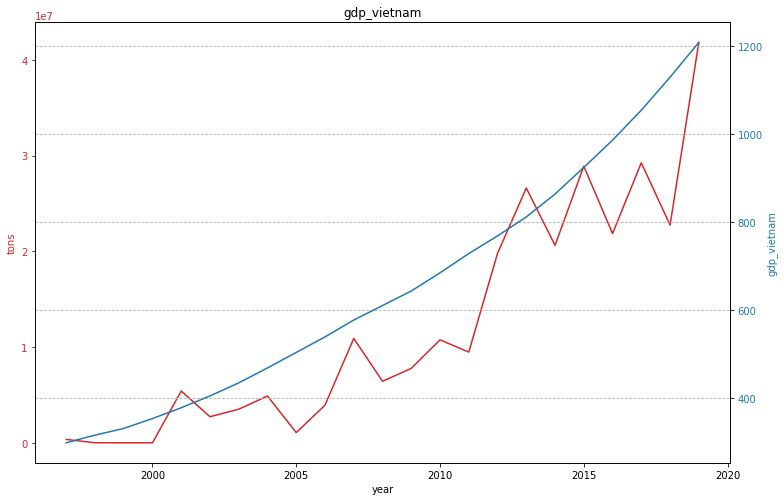

In [ ]:
# Comparing the behaviour of variables against the value aimed for prediction

for column in gdps:

  fig, ax1 = plt.subplots()

  color = 'tab:red'
  ax1.set_xlabel('year')
  ax1.set_ylabel('tons', color=color)
  ax1.plot(df_corn_yearly['year'], df_corn_yearly['tons'], color=color)
  ax1.tick_params(axis='y', labelcolor=color)

  ax2 = ax1.twinx()

  color = 'tab:blue'
  ax2.set_ylabel(column, color=color)
  ax2.plot(df_corn_yearly['year'], df_corn_yearly[column], color=color)
  ax2.tick_params(axis='y', labelcolor=color)

  fig.tight_layout() 
  plt.title(column)
  plt.grid(linestyle='dashed')
  plt.show()

In [24]:
# Now for prediction, firstly the dataset is divided to split the values aimed for
# prediction as well as subsets for training and model validation
X = df_corn_yearly.drop(columns=['year', 'tons']).values
y = df_corn_yearly['tons'].values
X_train = X[:-5,:]
X_test = X[-5:,:]
y_train = y[:-5]
y_test = y[-5:]

In [25]:
# Even thought the number of samples is small, multiple regression models will
# be tested to verify performance.

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import numpy as np

In [ ]:
model_list = []
model_list.append(('LR',LinearRegression()))
model_list.append(('LASSO', Lasso()))
model_list.append(('RIDGE', Ridge()))
model_list.append(('EN', ElasticNet()))
model_list.append(('KNN', KNeighborsRegressor()))
model_list.append(('CART', DecisionTreeRegressor()))
model_list.append(('GBM', GradientBoostingRegressor()))
model_list.append(('RFR', RandomForestRegressor()))
model_list.append(('XGB', XGBRegressor(objective='reg:squarederror')))
results = []
names = []
for name, model in model_list:
    modelo = model
    model.fit(X_train, y_train)
    
    results =np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
    msg = "RMSE for %s: %f " % (name, results)
    print(msg)
    results =r2_score(y_test, model.predict(X_test))
    msg2 = "R2 Score for %s: %f " % (name, results)
    print(msg2)

In [26]:
# Multicollinearity can badly affect regression models, as such, a test 
# without gdp_world is done

X = df_corn_yearly.drop(columns=['year', 'tons', 'gdp_world']).values
y = df_corn_yearly['tons'].values
X_train = X[:-5,:]
X_test = X[-5:,:]
y_train = y[:-5]
y_test = y[-5:]

In [41]:
# List of models to be tested on the dataset
model_list = []
model_list.append(('LR',LinearRegression()))
model_list.append(('LASSO', Lasso()))
model_list.append(('RIDGE', Ridge()))
model_list.append(('EN', ElasticNet()))
model_list.append(('KNN', KNeighborsRegressor()))
model_list.append(('CART', DecisionTreeRegressor()))
model_list.append(('GBM', GradientBoostingRegressor()))
model_list.append(('RFR', RandomForestRegressor()))
model_list.append(('XGB', XGBRegressor(objective='reg:squarederror')))

In [ ]:
results = []
names = []
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
for name, model in model_list:
    modelo = model
    model.fit(X_train, y_train)
    
    results =np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
    msg = "RMSE for %s: %f " % (name, results)
    print(msg)
    results =r2_score(y_test, model.predict(X_test))
    msg2 = "R2 Score for %s: %f " % (name, results)
    print(msg2)
  

RMSE for LR: 5185226.627605 
R2 Score for LR: 0.472221 
RMSE for LASSO: 5219561.944410 
R2 Score for LASSO: 0.465208 
RMSE for RIDGE: 5188176.882810 
R2 Score for RIDGE: 0.471620 
RMSE for EN: 5240085.264035 
R2 Score for EN: 0.460994 
RMSE for KNN: 13503265.752517 
R2 Score for KNN: -2.579271 
RMSE for CART: 10938969.861684 
R2 Score for CART: -1.348929 
RMSE for GBM: 11179846.081048 
R2 Score for GBM: -1.453515 
RMSE for RFR: 12267567.226649 
R2 Score for RFR: -1.954159 
RMSE for XGB: 11048296.817116 
R2 Score for XGB: -1.396115 


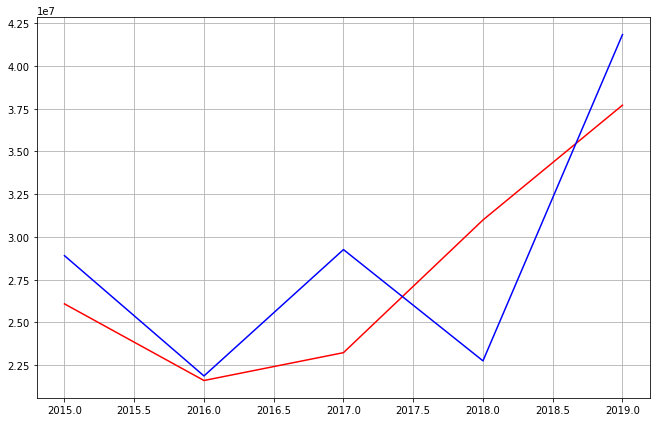

In [27]:
chosen = ElasticNet()
chosen.fit(X_train, y_train)

plt.plot(df_corn_yearly.iloc[-5:, 0].values, chosen.predict(X_test), color='red')
plt.plot(df_corn_yearly.iloc[-5:, 0].values, y_test, color='blue')
plt.grid()
plt.show()

In [ ]:
# defining ElasticNet as the regression model, the next step is to optimize the hyperparameters

def GridSearchEN(X_train, y_train, X_test, y_test, max_iter, alpha, l1_ratio):
	best_score, best_cfg = 0, None
	for i in max_iter:
		for j in alpha:
			for k in l1_ratio:
				params = (i,j,k)
					
				EN_model=ElasticNet(max_iter=i, alpha=j, l1_ratio=k)
				EN_model.fit(X_train, y_train)
				r2 = r2_score(y_test, EN_model.predict(X_test))
				if r2 > best_score:
					best_score, best_cfg = r2, params
				
	print('Best ElasticNet with %s r2 score=%.6f' % (best_cfg, best_score))

In [ ]:
max_iter = [500, 1000, 2000, 3500, 5000]
alpha = [0.001, 0.01, 0.1, 1, 10, 20, 40, 50, 100]
l1_ratio = np.arange(0.0, 1.0, 0.1)
GridSearchEN(X_train, y_train, X_test, y_test, max_iter, alpha, l1_ratio)

Best ElasticNet with (5000, 50, 0.9) r2 score=0.516748


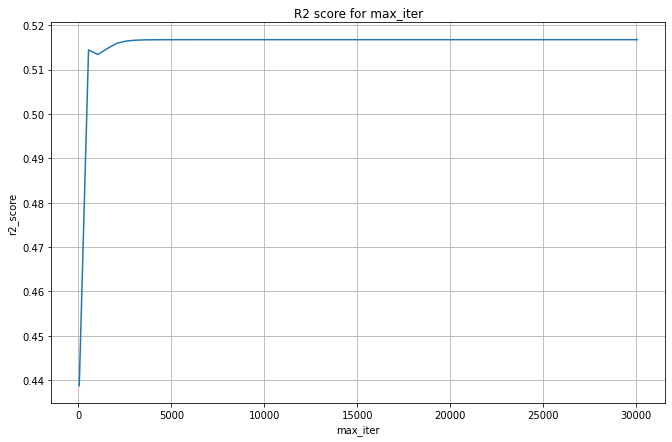

In [ ]:
# Plotting the variation for r2_score across values of max_iter

list_r2=[]
x_axis = []
for iter in range(50, 30500, 500):
  EN = ElasticNet(max_iter = iter, alpha = 50, l1_ratio = 0.9)
  EN.fit(X_train, y_train)
  r2 = r2_score(y_test, EN.predict(X_test))
  list_r2.append(r2)
  x_axis.append(iter)
plt.plot(x_axis, list_r2)
plt.title('R2 score for max_iter')
plt.xlabel('max_iter')
plt.ylabel('r2_score')
plt.grid()
plt.show()

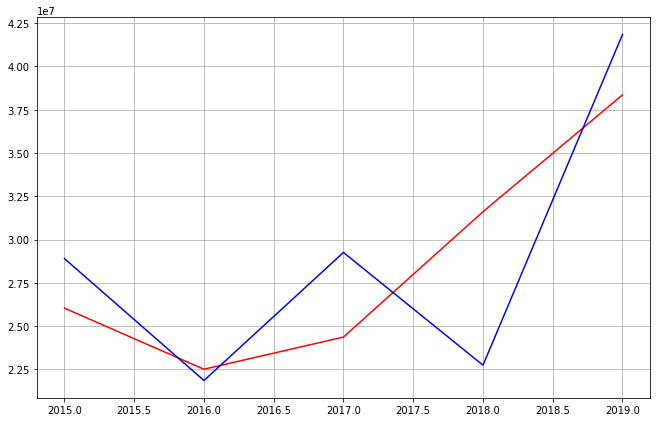

In [28]:
# thus, model performance does not seem to improve with further increases in the 
# number of maximum iterations, therefore the model can be defined 
corn_model = ElasticNet(max_iter = 5000, alpha = 50, l1_ratio = 0.9)
corn_model.fit(X_train, y_train)

plt.plot(df_corn_yearly.iloc[-5:, 0].values, corn_model.predict(X_test), color='red')
plt.plot(df_corn_yearly.iloc[-5:, 0].values, y_test, color='blue')
plt.grid()
plt.show()

### Product: Soybeans

In [29]:
df_soybeans_exp = df_exports.query("product == 'soybeans'")

In [ ]:
df_soybeans_exp

,date,product,state,country,type,route,tons,usd,year,month
73,1997-01-01,soybeans,GO,Spain,Export,Sea,13730.000,3954240.0,1997,1-1997
74,1997-01-01,soybeans,MT,Bolivia,Export,Other,100.000,60500.0,1997,1-1997
75,1997-01-01,soybeans,RS,Argentina,Export,Ground,200.000,104000.0,1997,1-1997
167,1997-02-01,soybeans,GO,Netherlands,Export,Sea,3000.000,855450.0,1997,2-1997
168,1997-02-01,soybeans,MT,Netherlands,Export,Sea,5000.000,1436185.0,1997,2-1997
...,...,...,...,...,...,...,...,...,...,...
117584,2019-12-01,soybeans,SP,Liberia,Export,Other,0.004,11.0,2019,12-2019
117585,2019-12-01,soybeans,SP,Liberia,Export,Other,0.006,30.0,2019,12-2019
117586,2019-12-01,soybeans,SP,Thailand,Export,Sea,146.499,52813.0,2019,12-2019
117587,2019-12-01,soybeans,TO,China,Export,Sea,63731.482,22986541.0,2019,12-2019


In [ ]:
print(df_soybeans_exp.groupby('country', as_index=False)['tons'].sum().sort_values('tons', ascending=False).head(15))

            country          tons
18            China  4.621120e+08
63      Netherlands  5.632898e+07
86            Spain  4.093810e+07
94         Thailand  1.878095e+07
35          Germany  1.865859e+07
48            Italy  1.270832e+07
93           Taiwan  1.239956e+07
49            Japan  1.147099e+07
45             Iran  1.082491e+07
101  United Kingdom  1.002976e+07
75         Portugal  9.888874e+06
67           Norway  7.786021e+06
85      South Korea  7.728578e+06
78           Russia  6.324404e+06
31           France  5.668773e+06


In [30]:
df_soybeans_yearly = df_soybeans_exp.groupby('year', as_index=False)['tons'].sum()

In [31]:
# Now adding the new data from the covariates files

df_soybeans_yearly = df_soybeans_yearly.merge(df_covariates, left_on='year', right_on='year', how='left')

In [32]:
# Droping the columns which refers to other products

df_soybeans_yearly.drop(columns=['price_corn', 'price_soybean_meal'], inplace=True)

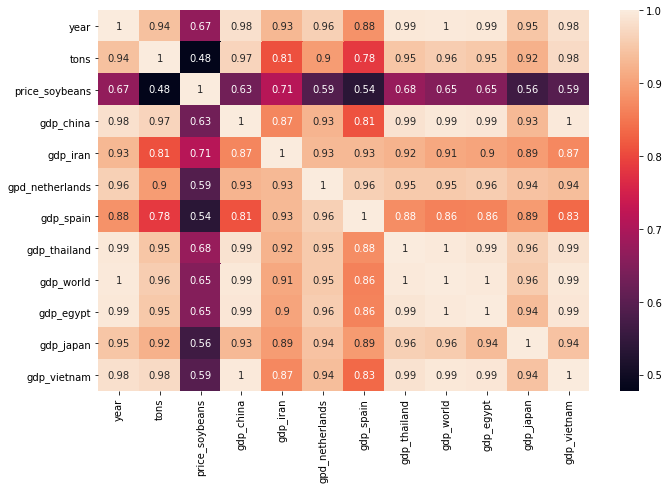

In [ ]:
# Checking for correlations between variables

sns.heatmap(df_soybeans_yearly.corr(), annot=True)
plt.show()

In [ ]:
gdps_soybeans = list(df_covariates.columns)
to_remove = ['year', 'price_corn', 'price_soybean_meal']
gdps_soybeans = [e for e in gdps_soybeans if e not in to_remove]
gdps_soybeans

['price_soybeans',
 'gdp_china',
 'gdp_iran',
 'gpd_netherlands',
 'gdp_spain',
 'gdp_thailand',
 'gdp_world',
 'gdp_egypt',
 'gdp_japan',
 'gdp_vietnam']

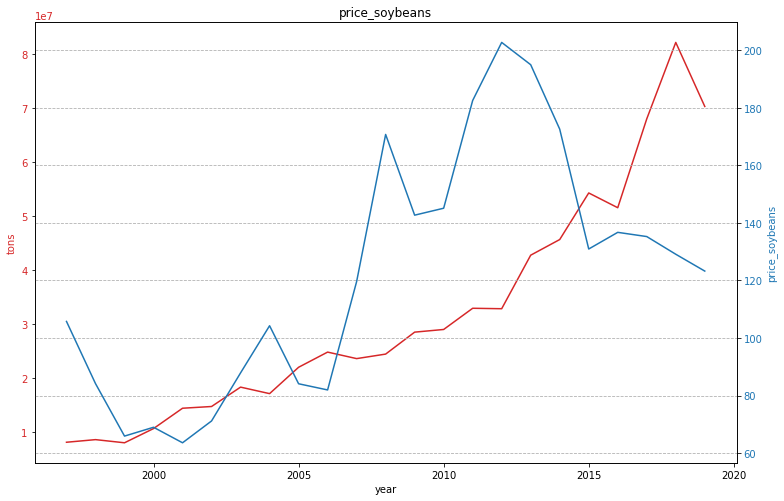

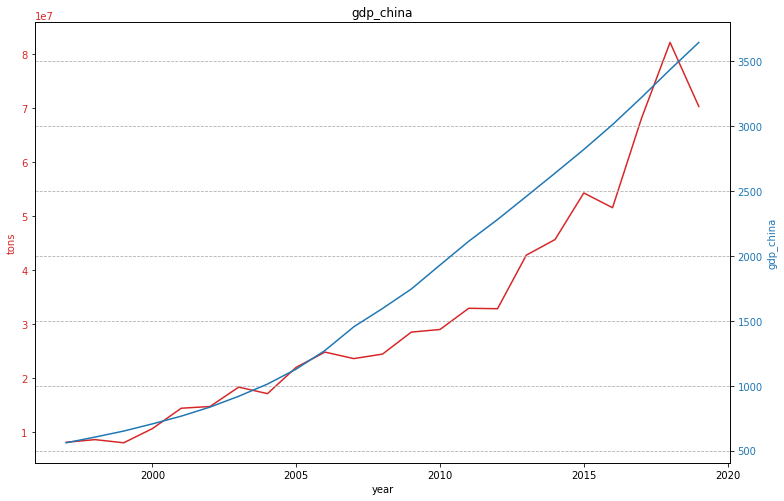

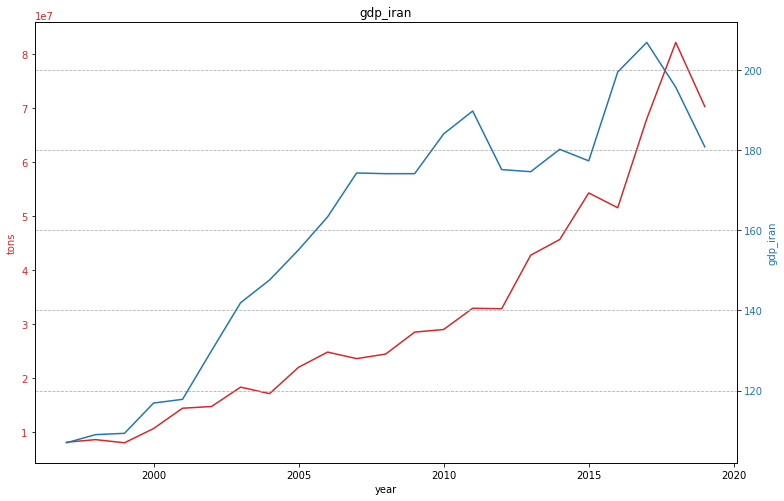

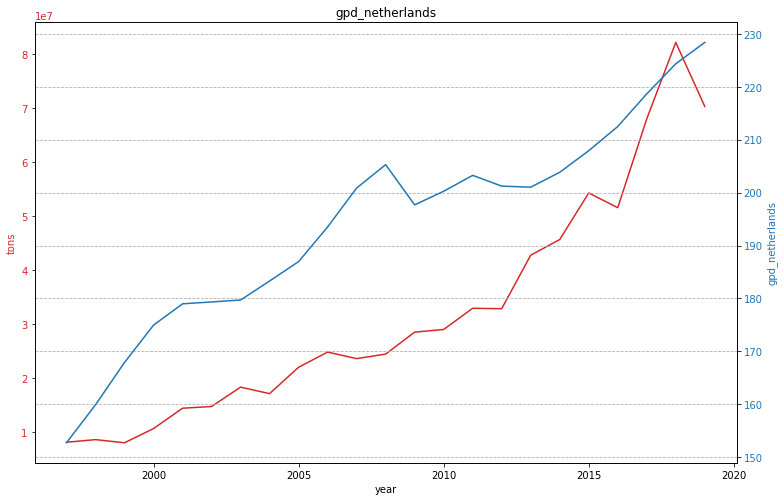

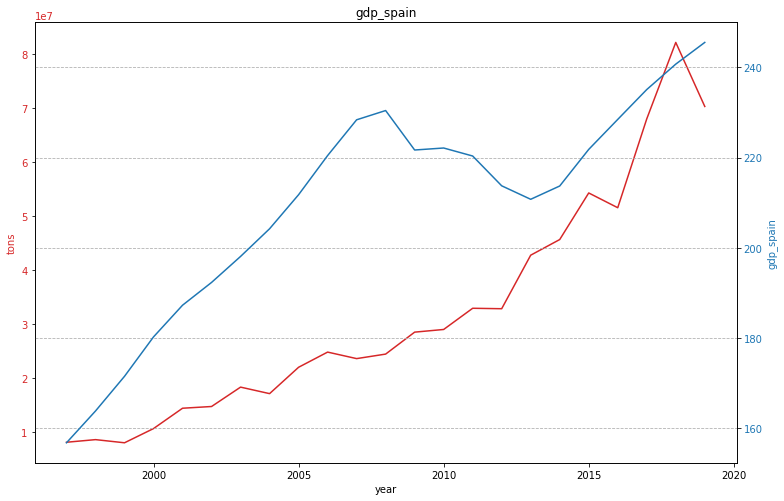

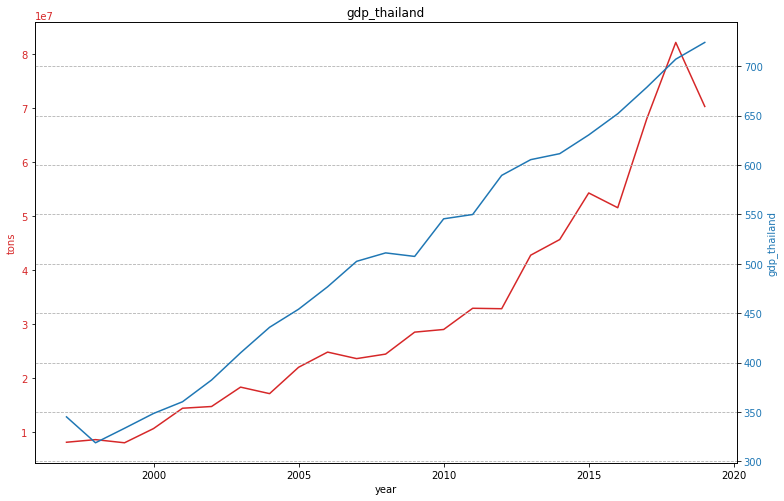

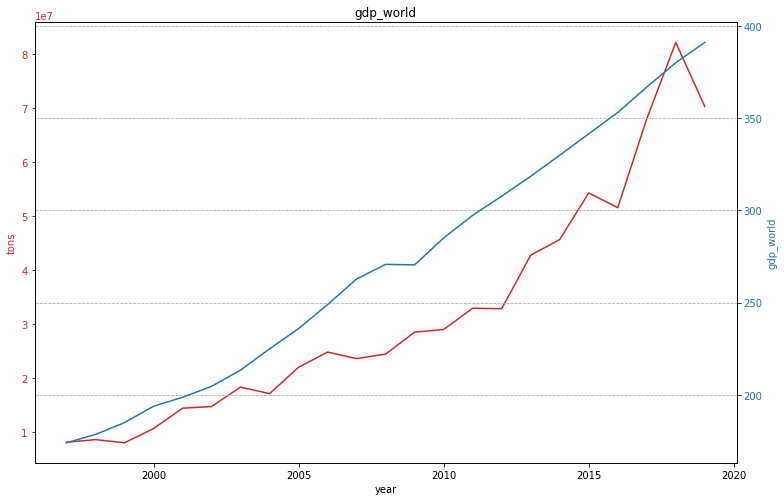

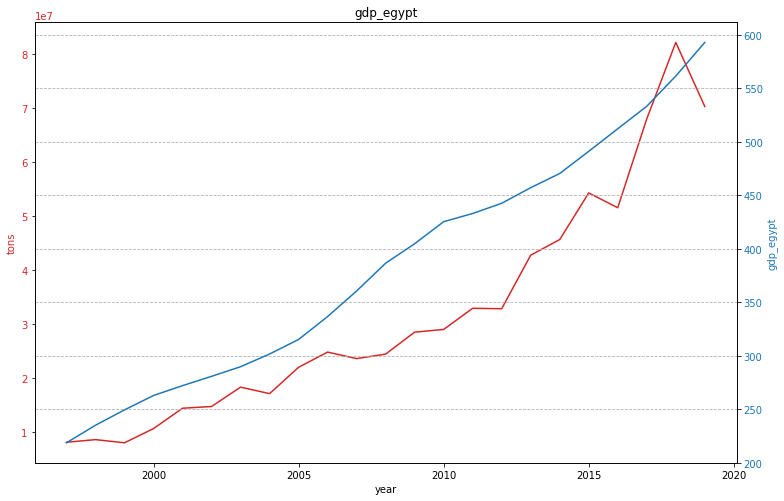

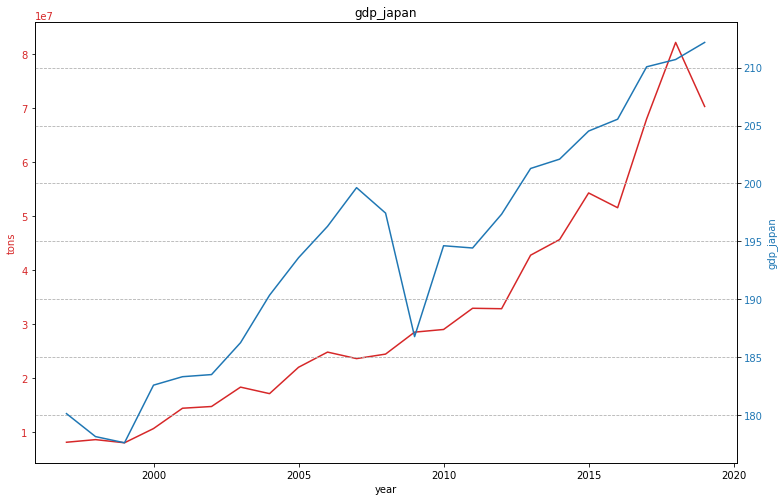

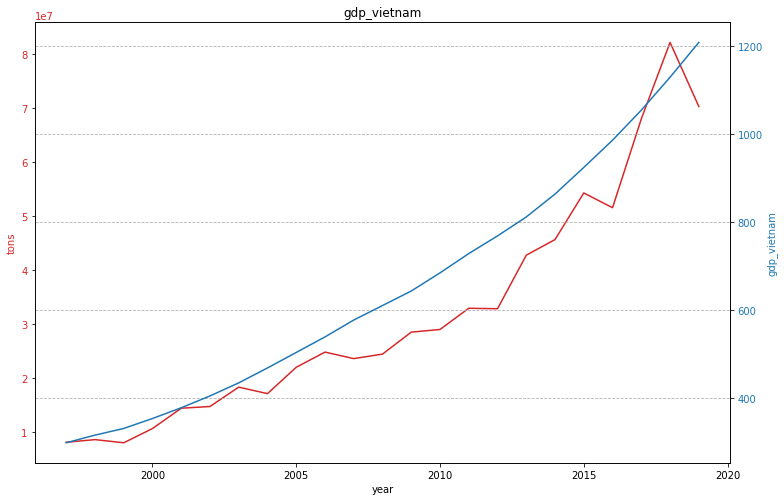

In [ ]:
# Comparing the behaviour of variables against the value aimed for prediction

for column in gdps_soybeans:

  fig, ax1 = plt.subplots()

  color = 'tab:red'
  ax1.set_xlabel('year')
  ax1.set_ylabel('tons', color=color)
  ax1.plot(df_soybeans_yearly['year'], df_soybeans_yearly['tons'], color=color)
  ax1.tick_params(axis='y', labelcolor=color)

  ax2 = ax1.twinx()

  color = 'tab:blue'
  ax2.set_ylabel(column, color=color)
  ax2.plot(df_soybeans_yearly['year'], df_soybeans_yearly[column], color=color)
  ax2.tick_params(axis='y', labelcolor=color)

  fig.tight_layout()
  plt.title(column)
  plt.grid(linestyle='dashed',which='both')
  plt.show()

In [33]:
X = df_soybeans_yearly.drop(columns=['year', 'tons']).values
y = df_soybeans_yearly['tons'].values
X_train = X[:-5,:]
X_test = X[-5:,:]
y_train = y[:-5]
y_test = y[-5:]

In [ ]:
results = []
names = []
for name, model in model_list:
    modelo = model
    model.fit(X_train, y_train)
    
    results =np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
    msg = "RMSE for %s: %f " % (name, results)
    print(msg)
    results =r2_score(y_test, model.predict(X_test))
    msg = "R2 Score for %s: %f " % (name, results)
    print(msg)
  

RMSE for LR: 13802449.832030 
R2 Score for LR: -0.522869 
RMSE for LASSO: 7600051.105618 
R2 Score for LASSO: 0.538275 
RMSE for RIDGE: 12623833.115037 
R2 Score for RIDGE: -0.273892 
RMSE for EN: 7356476.771032 
R2 Score for EN: 0.567397 
RMSE for KNN: 30695916.820447 
R2 Score for KNN: -6.532018 
RMSE for CART: 22548602.802891 
R2 Score for CART: -3.064334 
RMSE for GBM: 25912641.193553 
R2 Score for GBM: -4.367518 
RMSE for RFR: 29544218.348820 
R2 Score for RFR: -5.977425 
RMSE for XGB: 27212939.640381 
R2 Score for XGB: -4.919719 


In [ ]:
max_iter = [500, 1000, 2000, 3500, 5000]
alpha = [0.001, 0.01, 0.1, 1, 10, 20, 40, 50, 100]
l1_ratio = np.arange(0.0, 1.0, 0.1)
GridSearchEN(X_train, y_train, X_test, y_test, max_iter, alpha, l1_ratio)

Best ElasticNet with (5000, 40, 0.8) r2 score=0.601105


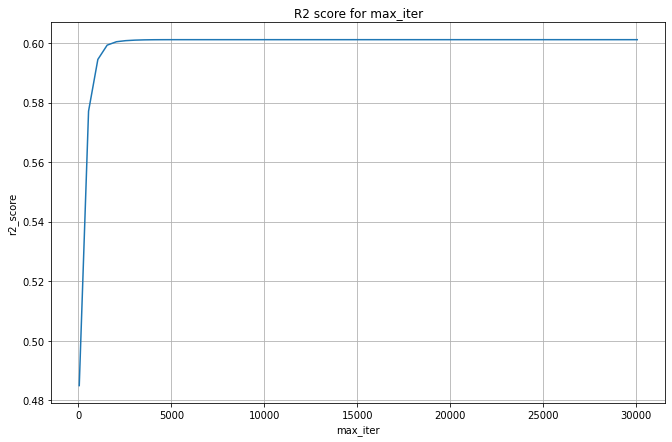

In [ ]:
# Plotting the variation for r2_score across values of max_iter
list_r2=[]
x_axis = []
for iter in range(50, 30500, 500):
  EN = ElasticNet(max_iter = iter, alpha = 40, l1_ratio = 0.8)
  EN.fit(X_train, y_train)
  r2 = r2_score(y_test, EN.predict(X_test))
  list_r2.append(r2)
  x_axis.append(iter)
plt.plot(x_axis, list_r2)
plt.title('R2 score for max_iter')
plt.xlabel('max_iter')
plt.ylabel('r2_score')
plt.grid()
plt.show()

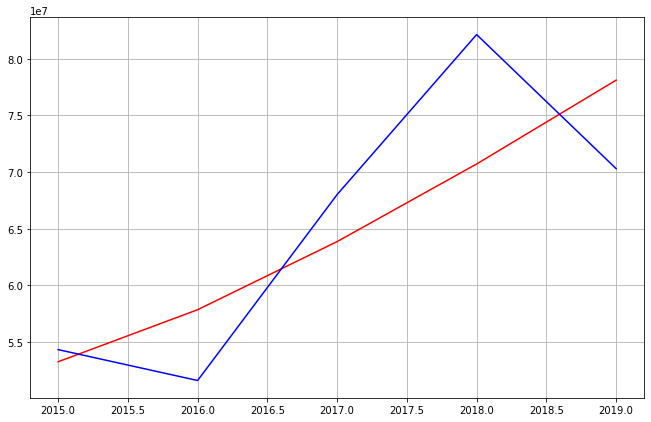

In [34]:
soybeans_model = ElasticNet(max_iter = 5000, alpha = 40, l1_ratio = 0.8)
soybeans_model.fit(X_train, y_train)

plt.plot(df_soybeans_yearly.iloc[-5:, 0].values, soybeans_model.predict(X_test), color='red')
plt.plot(df_soybeans_yearly.iloc[-5:, 0].values, y_test, color='blue')
plt.grid()
plt.show()

### Product: Soybean meal

In [35]:
df_soymeal_exp = df_exports.query("product == 'soybean_meal'")

In [ ]:
df_soymeal_exp

,date,product,state,country,type,route,tons,usd,year,month
19,1997-01-01,soybean_meal,GO,Netherlands,Export,Sea,419.070,119318.0,1997,1-1997
20,1997-01-01,soybean_meal,GO,Netherlands,Export,Sea,5000.000,1414250.0,1997,1-1997
21,1997-01-01,soybean_meal,MS,Germany,Export,Sea,140.672,38378.0,1997,1-1997
22,1997-01-01,soybean_meal,MS,Hungary,Export,Sea,15000.000,4042100.0,1997,1-1997
23,1997-01-01,soybean_meal,MS,Netherlands,Export,Sea,14000.000,3850162.0,1997,1-1997
...,...,...,...,...,...,...,...,...,...,...
117367,2019-12-01,soybean_meal,SP,United Kingdom,Export,Sea,2259.887,800000.0,2019,12-2019
117368,2019-12-01,soybean_meal,SP,Vietnam,Export,Sea,17300.000,5803448.0,2019,12-2019
117369,2019-12-01,soybean_meal,TO,France,Export,Sea,1537.455,466218.0,2019,12-2019
117370,2019-12-01,soybean_meal,TO,South Korea,Export,Sea,2933.194,889462.0,2019,12-2019


In [ ]:
print(df_soymeal_exp.groupby('country', as_index=False)['tons'].sum().sort_values('tons', ascending=False).head(15))

            country          tons
75      Netherlands  7.143900e+07
38           France  4.798891e+07
41          Germany  2.441484e+07
109        Thailand  2.302451e+07
100     South Korea  1.884746e+07
54        Indonesia  1.574236e+07
101           Spain  1.129183e+07
98         Slovenia  8.684694e+06
58            Italy  8.620098e+06
55             Iran  8.474662e+06
115  United Kingdom  6.644938e+06
92          Romania  5.669285e+06
119         Vietnam  4.864511e+06
94     Saudi Arabia  4.055867e+06
30          Denmark  3.962325e+06


In [36]:
df_soymeal_yearly = df_soymeal_exp.groupby('year', as_index=False)['tons'].sum()

In [37]:
# Now adding the new data from the covariates files

df_soymeal_yearly = df_soymeal_yearly.merge(df_covariates, left_on='year', right_on='year', how='left')

In [38]:
# Droping the columns which refers to other products

df_soymeal_yearly.drop(columns=['price_corn', 'price_soybeans'], inplace=True)

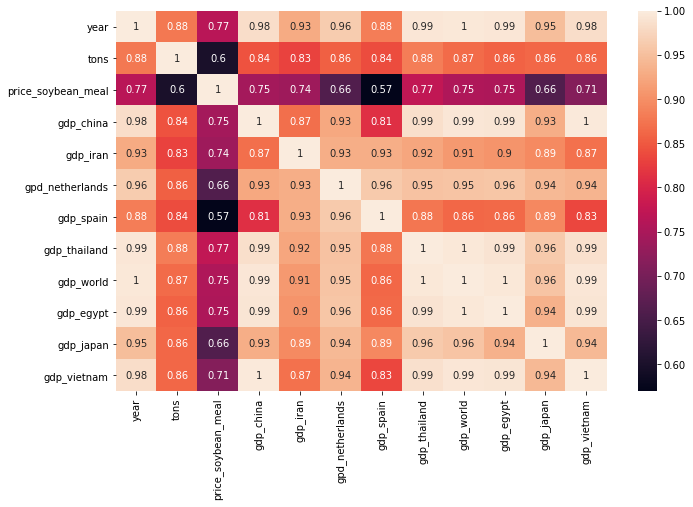

In [ ]:
# Checking for correlations between variables

sns.heatmap(df_soymeal_yearly.corr(), annot=True)
plt.show()

In [ ]:
gdps_soymeal = list(df_covariates.columns)
to_remove = ['year', 'price_corn', 'price_soybeans']
gdps_soymeal = [e for e in gdps_soymeal if e not in to_remove]
gdps_soymeal

['price_soybean_meal',
 'gdp_china',
 'gdp_iran',
 'gpd_netherlands',
 'gdp_spain',
 'gdp_thailand',
 'gdp_world',
 'gdp_egypt',
 'gdp_japan',
 'gdp_vietnam']

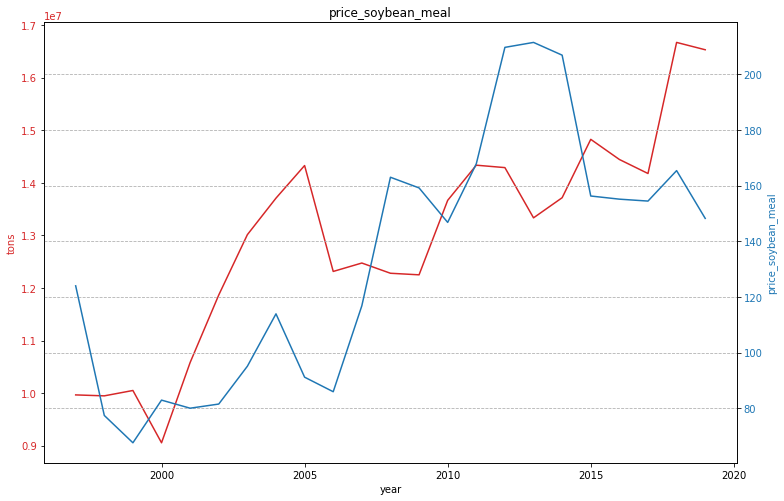

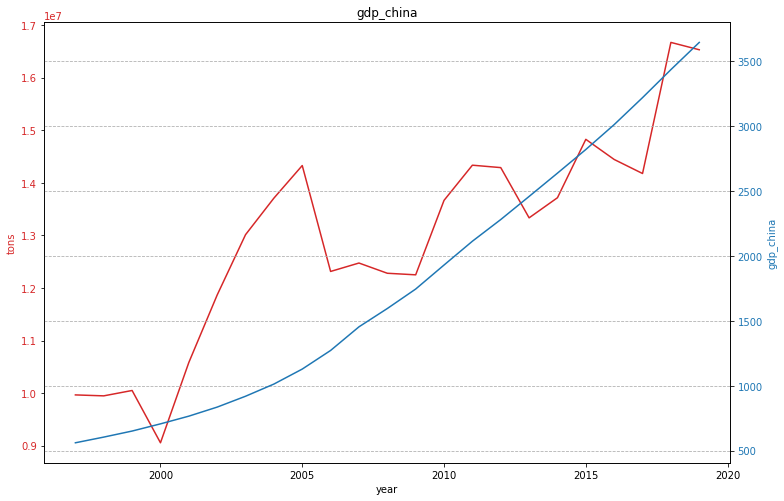

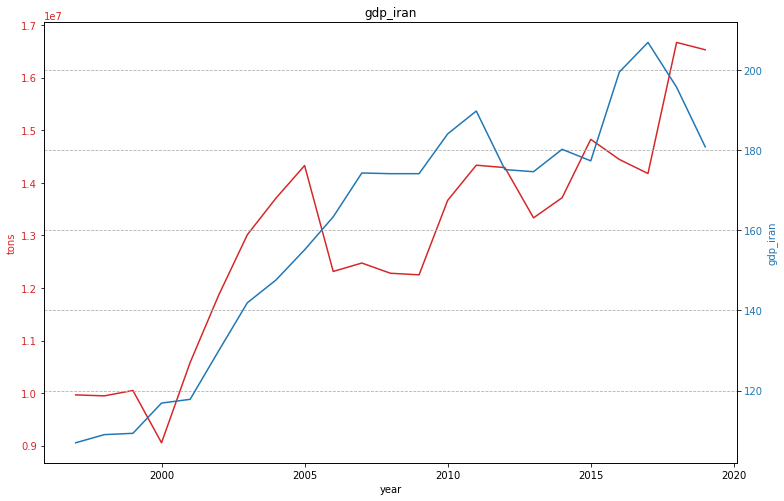

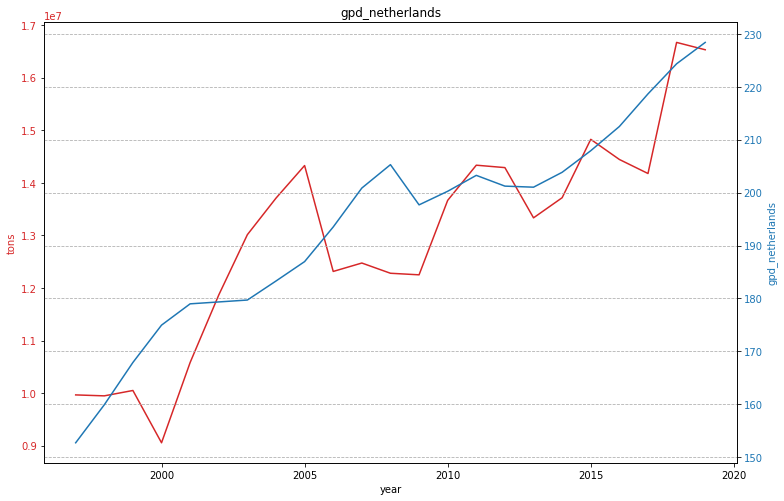

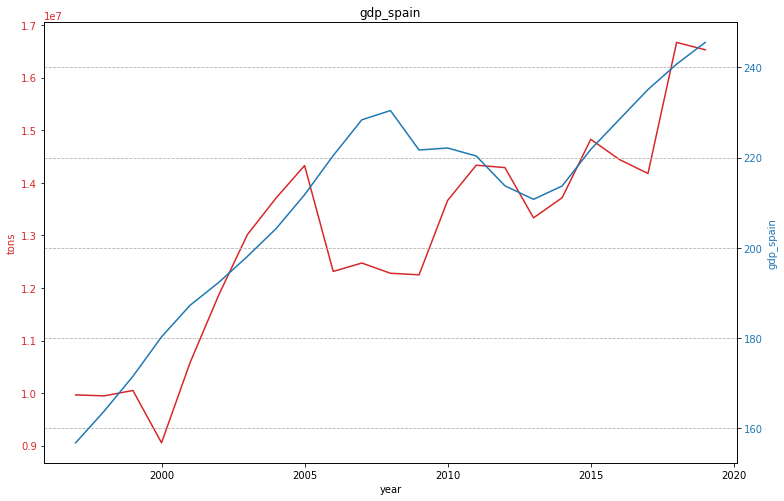

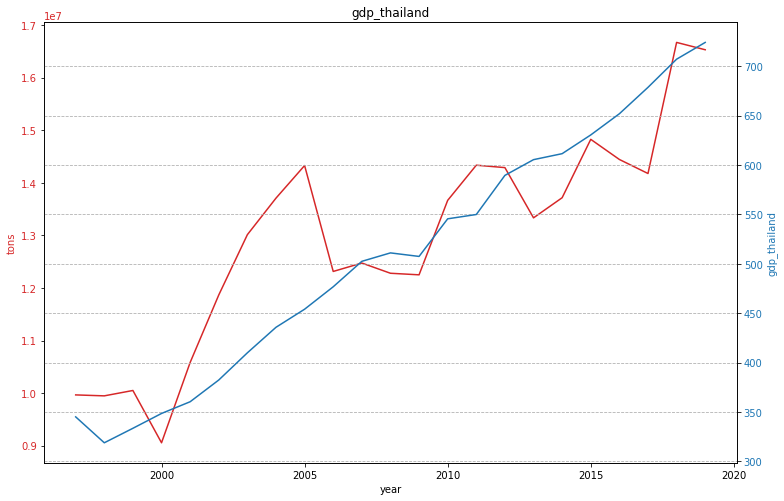

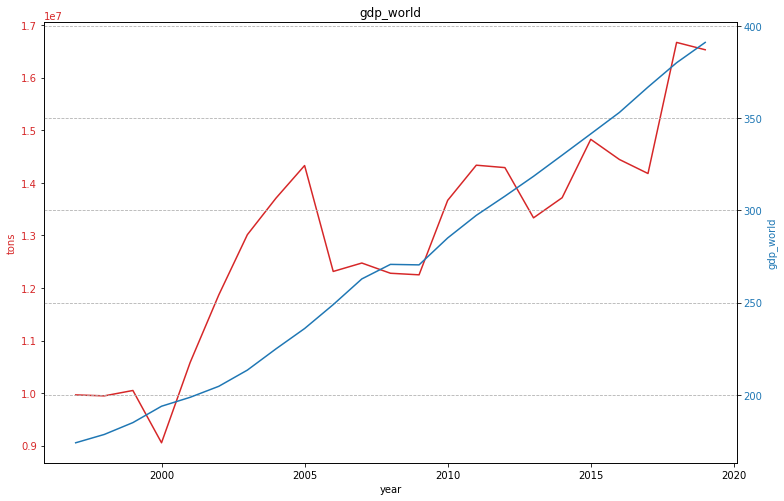

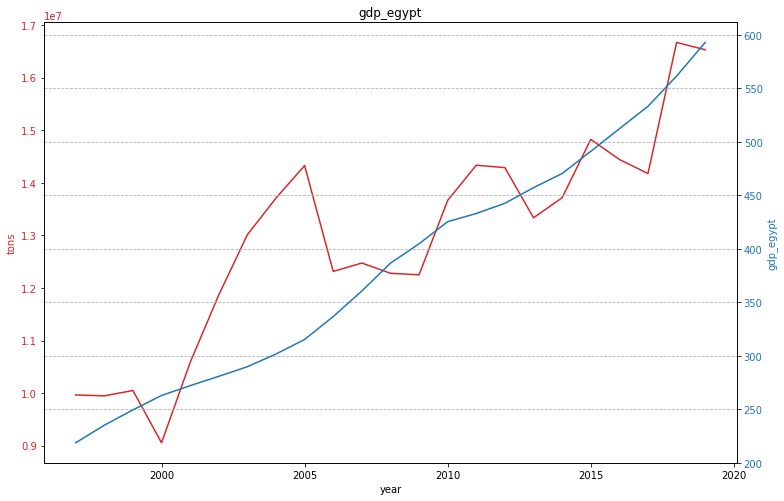

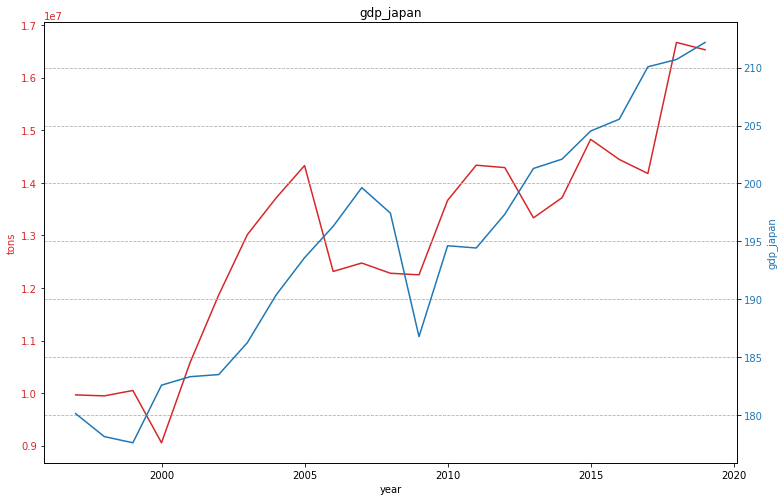

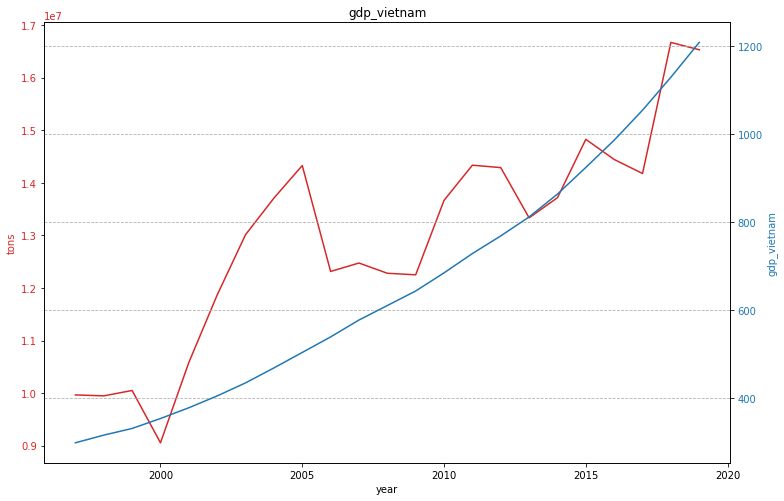

In [ ]:
# Comparing the behaviour of variables against the value aimed for prediction

for column in gdps_soymeal:

  fig, ax1 = plt.subplots()

  color = 'tab:red'
  ax1.set_xlabel('year')
  ax1.set_ylabel('tons', color=color)
  ax1.plot(df_soymeal_yearly['year'], df_soymeal_yearly['tons'], color=color)
  ax1.tick_params(axis='y', labelcolor=color)

  ax2 = ax1.twinx()

  color = 'tab:blue'
  ax2.set_ylabel(column, color=color)
  ax2.plot(df_soymeal_yearly['year'], df_soymeal_yearly[column], color=color)
  ax2.tick_params(axis='y', labelcolor=color)

  fig.tight_layout()
  plt.title(column)
  plt.grid(linestyle='dashed')
  plt.show()

In [39]:
X = df_soymeal_yearly.drop(columns=['year', 'tons']).values
y = df_soymeal_yearly['tons'].values
X_train = X[:-5,:]
X_test = X[-5:,:]
y_train = y[:-5]
y_test = y[-5:]

In [42]:
results = []
names = []
for name, model in model_list:
    modelo = model
    model.fit(X_train, y_train)
    
    results =np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
    msg = "RMSE for %s: %f " % (name, results)
    print(msg)
    results =r2_score(y_test, model.predict(X_test))
    msg = "R2 Score for %s: %f " % (name, results)
    print(msg)

RMSE for LR: 2794906.968496 
R2 Score for LR: -5.968052 
RMSE for LASSO: 2438971.926783 
R2 Score for LASSO: -4.306281 
RMSE for RIDGE: 2727582.136888 
R2 Score for RIDGE: -5.636397 
RMSE for EN: 2317909.396100 
R2 Score for EN: -3.792582 
RMSE for KNN: 1804741.587849 
R2 Score for KNN: -1.905405 
RMSE for CART: 1452697.549996 
R2 Score for CART: -0.882466 
RMSE for GBM: 2116148.828588 
R2 Score for GBM: -2.994561 
RMSE for RFR: 2266214.869819 
R2 Score for RFR: -3.581196 
RMSE for XGB: 3017463.668191 
R2 Score for XGB: -7.121959 


In [43]:
# Applying MinMaxScaler in the training and testing inputs

results = []
names = []
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
for name, model in model_list:
    modelo = model
    model.fit(X_train_scaled, y_train)
    
    results =np.sqrt(mean_squared_error(y_test, model.predict(X_test_scaled)))
    msg = "RMSE for %s: %f " % (name, results)
    print(msg)
    results =r2_score(y_test, model.predict(X_test_scaled))
    msg = "R2 Score for %s: %f " % (name, results)
    print(msg)

RMSE for LR: 2794906.968496 
R2 Score for LR: -5.968052 
RMSE for LASSO: 2438353.465016 
R2 Score for LASSO: -4.303591 
RMSE for RIDGE: 943865.119245 
R2 Score for RIDGE: 0.205312 
RMSE for EN: 1468378.256300 
R2 Score for EN: -0.923324 
RMSE for KNN: 1804741.587849 
R2 Score for KNN: -1.905405 
RMSE for CART: 1452697.549996 
R2 Score for CART: -0.882466 
RMSE for GBM: 2133214.254871 
R2 Score for GBM: -3.059248 
RMSE for RFR: 2406410.329237 
R2 Score for RFR: -4.165544 
RMSE for XGB: 3017463.668191 
R2 Score for XGB: -7.121959 


The MinMaxScaler was also tried in other products, as it is generally better do scale data for some of the models utilized, but in the other cases it resulted in a poorer result when compared to a non-scaled dataset.

In [ ]:
def GridSearchRidge(X_train, y_train, X_test, y_test, alpha):
	best_score, best_cfg = 0, None
	for i in alpha:
				params = i
				scaler = MinMaxScaler()
				X_train_scaled = scaler.fit_transform(X_train)
				X_test_scaled = scaler.transform(X_test)
				Ridge_model=Ridge(alpha=i)
				Ridge_model.fit(X_train_scaled, y_train)
				r2 = r2_score(y_test, Ridge_model.predict(X_test_scaled))
				if r2 > best_score:
					best_score, best_cfg = r2, params
				
	print('Best Ridge with %s r2 score=%.6f' % (best_cfg, best_score))

In [ ]:
alpha = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5,10, 20]

GridSearchRidge(X_train, y_train, X_test, y_test, alpha)

Best Ridge with 1 r2 score=0.205312


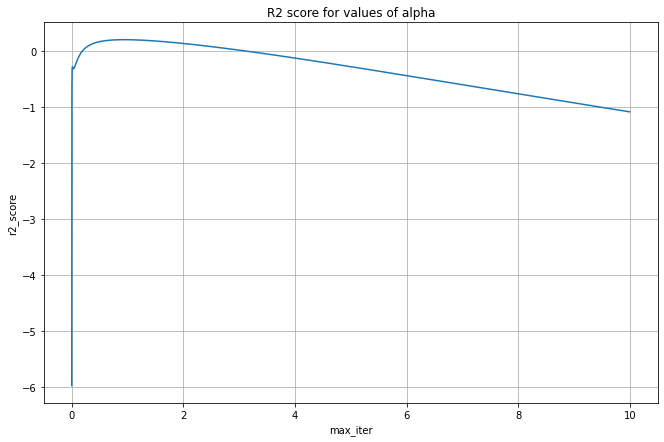

In [ ]:
# Plotting the variation for r2_score across values of alpha
list_r2=[]
x_axis = []
for iter in list(np.arange(1e-5, 10, 1e-4)):
  Rdg = Ridge(alpha = iter)
  Rdg.fit(X_train_scaled, y_train)
  r2 = r2_score(y_test, Rdg.predict(X_test_scaled))
  list_r2.append(r2)
  x_axis.append(iter)
plt.plot(x_axis, list_r2)
plt.title('R2 score for values of alpha')
plt.xlabel('max_iter')
plt.ylabel('r2_score')
plt.grid()
plt.show()

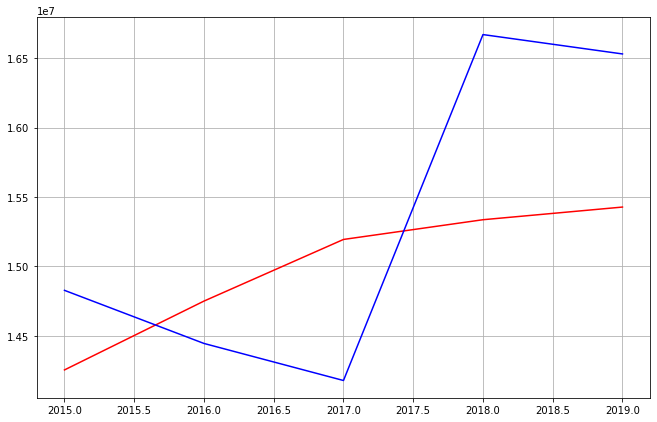

In [44]:
soybean_meal_model = Ridge(alpha=1)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
soybean_meal_model.fit(X_train_scaled, y_train)

plt.plot(df_soymeal_yearly.iloc[-5:, 0].values, soybean_meal_model.predict(X_test_scaled), color='red')
plt.plot(df_soymeal_yearly.iloc[-5:, 0].values, y_test, color='blue')
plt.grid()
plt.show()

### 2020 - 2030 Predictions

In [45]:
df_2020_2030 = df_covariates.query("year >= 2020")

In [46]:
# Separating the dataset for each product

corn_predict = df_2020_2030.drop(columns=['year', 'price_soybean_meal', 'price_soybeans', 'gdp_world'])

soybeans_predict = df_2020_2030.drop(columns=['year', 'price_soybean_meal', 'price_corn'])

soybean_meal_predict = df_2020_2030.drop(columns=['year', 'price_soybeans', 'price_corn'])

In [47]:
# Predicting values
corn_predict['tons'] = corn_model.predict(corn_predict)

soybeans_predict['tons'] = soybeans_model.predict(soybeans_predict)

soybean_meal_predict['tons'] = soybean_meal_model.predict(scaler.transform(soybean_meal_predict))

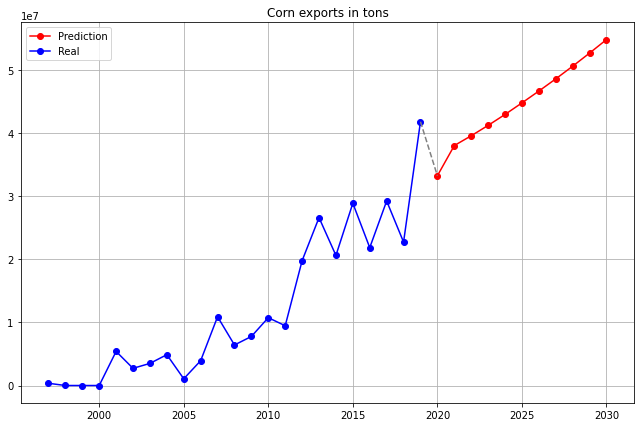

Predicted Corn Exports (tons):


2020    33258133.833
2021    38047303.537
2022    39599903.543
2023    41245783.943
2024    42979372.362
2025    44810891.129
2026    46686068.043
2027    48619925.754
2028    50629046.885
2029    52708313.397
2030    54852388.229
dtype: object

In [66]:
# Prediction values and graph for corn

plt.plot(df_2020_2030['year'], corn_predict['tons'], marker='o', label = 'Prediction', color='red')
plt.plot(df_corn_yearly['year'], df_corn_yearly['tons'], marker='o', label = 'Real', color='blue')
plt.plot([2019, 2020], [df_corn_yearly['tons'].values[-1], corn_predict['tons'].values[0]], linestyle = 'dashed', color='grey')
plt.legend(loc='upper left')
plt.title('Corn exports in tons')
plt.grid()
plt.show()

corn_values = pd.Series(data=corn_predict['tons'].values, index = df_2020_2030['year'].values)
print('Predicted Corn Exports (tons):')
corn_values.apply(lambda x: '%.3f' % x)

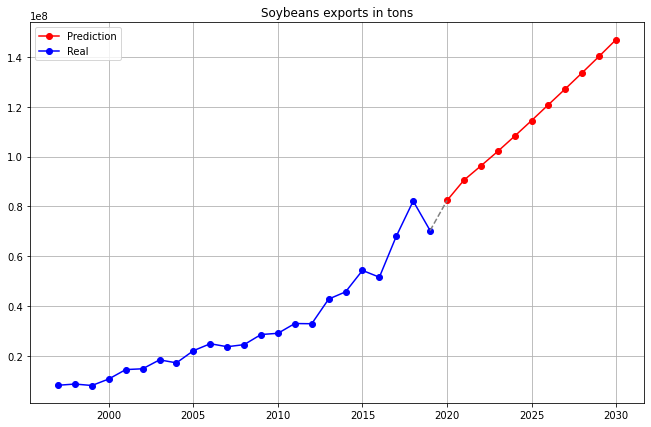

Predicted Soybeans Exports (tons):


2020     82368738.624
2021     90528662.875
2022     96237138.028
2023    102077954.662
2024    108204663.444
2025    114457288.655
2026    120850200.418
2027    127217156.919
2028    133698471.519
2029    140283439.150
2030    146970410.508
dtype: object

In [65]:
# Prediction values and graph for soybeans

plt.plot(df_2020_2030['year'], soybeans_predict['tons'], marker='o', label = 'Prediction', color='red')
plt.plot(df_soybeans_yearly['year'], df_soybeans_yearly['tons'], marker='o', label = 'Real', color='blue')
plt.plot([2019, 2020], [df_soybeans_yearly['tons'].values[-1], soybeans_predict['tons'].values[0]], linestyle = 'dashed', color='grey')
plt.legend(loc='upper left')
plt.title('Soybeans exports in tons')
plt.grid()
plt.show()

soybeans_values = pd.Series(data=soybeans_predict['tons'].values, index = df_2020_2030['year'].values)
print('Predicted Soybeans Exports (tons):')
soybeans_values.apply(lambda x: '%.3f' % x)

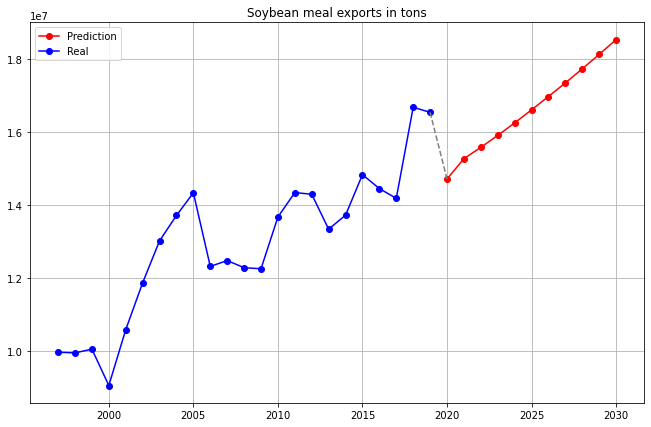

Predicted Soybean Meal Exports (tons):


2020    14706395.487
2021    15262545.294
2022    15572715.097
2023    15898727.812
2024    16241059.887
2025    16599451.293
2026    16963581.063
2027    17336033.737
2028    17720616.488
2029    18116090.379
2030    18521754.043
dtype: object

In [64]:
# Prediction values and graph for soybeans

plt.plot(df_2020_2030['year'], soybean_meal_predict['tons'], marker='o', label = 'Prediction', color='red')
plt.plot(df_soymeal_yearly['year'], df_soymeal_yearly['tons'], marker='o', label = 'Real', color='blue')
plt.plot([2019, 2020], [df_soymeal_yearly['tons'].values[-1], soybean_meal_predict['tons'].values[0]], linestyle = 'dashed', color='grey')
plt.legend(loc='upper left')
plt.title('Soybean meal exports in tons')
plt.grid()
plt.show()

soybean_meal_values = pd.Series(data=soybean_meal_predict['tons'].values, index = df_2020_2030['year'].values)
print('Predicted Soybean Meal Exports (tons):')
soybean_meal_values.apply(lambda x: '%.3f' % x)